## Minimum spanning tree of all homes.
Read
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
https://networkx.org/documentation/networkx-1.10/reference/introduction.html#networkx-basics

https://networkx.org/documentation/networkx-1.10/reference/algorithms.mst.html


In [1]:
import time
import networkx as nx #tree stuff
import geopandas as gp
import pandas as pd
from math import radians, sin, cos, asin, sqrt
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN
from shapely.geometry import Point
from shapely.geometry import LineString

In [2]:
#Set Parameters
epsilon = 0.0029
minsamples = 50
citypop = 1100

In [3]:
# A sample of buildings, assumed to be buildings to place in ONE distribution grid

# TODO Check you have the datafile in the write place
#buildings = 'SmallSample_OSMbuildings.geojson'
buildings = 'SLE_KenemaRadius_OSMBuildings.geojson'

print('Loading data...')
# Prepare building data - read as geodataframe
gdf = gp.read_file(buildings)
# Get the number of rows (points) in the GeoDataFrame
no_points = gdf.shape[0]
gdf.to_excel('Kenema.xlsx')
gdf

Loading data...


osm_id  code    fclass  name  type  \
0      194636169  1500  building  None  None   
1      194636173  1500  building  None  None   
2      194636191  1500  building  None  None   
3      194636195  1500  building  None  None   
4      194636203  1500  building  None  None   
...          ...   ...       ...   ...   ...   
43745  561198539  1500  building  None  None   
43746  561198540  1500  building  None  None   
43747  561198541  1500  building  None  None   
43748  561198542  1500  building  None  None   
43749  745687152  1500  building  None  None   

                                                geometry  
0      MULTIPOLYGON (((-11.36684 7.99306, -11.36680 7...  
1      MULTIPOLYGON (((-11.36671 7.99309, -11.36670 7...  
2      MULTIPOLYGON (((-11.36670 7.99296, -11.36668 7...  
3      MULTIPOLYGON (((-11.36686 7.99279, -11.36679 7...  
4      MULTIPOLYGON (((-11.36661 7.99295, -11.36657 7...  
...                                                  ...  
43745  MULTIPOLYGON (((-11.32693 8.02009, -11.32690 8...  
43746  MULTIPOLYGON (((-11.32677 8.02022, -11.32677 8...  
43747  MULTIPOLYGON (((-11.32686 8.02023, -11.32685 8...  
43748  MULTIPOLYGON (((-11.32678 8.02062, -11.32667 8...  
43749  MULTIPOLYGON (((-11.05620 7.69078, -11.05611 7...  

[43750 rows x 6 columns]

In [4]:
# Get centroid points of building polygons
gdf['centroid'] = gdf['geometry'].centroid
# Break out lat and long into separate columns of GeoDataFrame
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y
# Get lat and long columns from the GeoDataFrame and convert into a numpy array
coords = gdf.drop(['name', 'type', 'code', 'fclass', 'osm_id', 'geometry', 'centroid'], axis=1).to_numpy()
# You will get a warning.
#gdf

C:\Users\micae\AppData\Local\Temp/ipykernel_3040/2190634841.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid
C:\Users\micae\AppData\Local\Temp/ipykernel_3040/2190634841.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
C:\Users\micae\AppData\Local\Temp/ipykernel_3040/2190634841.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


Building Map


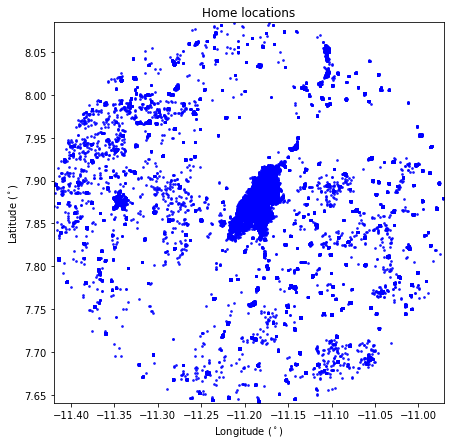

In [5]:
# Plot home locations
plt.figure(figsize=(7, 7))
plt.title('Home locations')
plt.scatter(x=coords[:, 0], y=coords[:, 1],color='b', s=3, alpha=0.8)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
axes = plt.gca()
axes.set_xlim([min(coords[:, 0]) - 0.001, max(coords[:, 0]) + 0.001])
axes.set_ylim([min(coords[:, 1]) - 0.001, max(coords[:, 1]) + 0.001])

print("Building Map")

In [6]:
# Haversine formula for kilometer distance between two lat/long points
def haversine_dist_from_coords(lat1, lon1, lat2, lon2):
    # The math module contains a function named radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    # calculate and return the result
    return c * r


In [7]:
def makeatree(coords,center,j): #3 variables, coords, centroid or not (use 1 for centroids, 0 for else), and i for group nr 
    df = pd.DataFrame(columns = ['Line', 'Cluster'])#'Cluster Number',                 
    dff = pd.DataFrame(columns = ['Cluster', 'Dwellings', 'Cable length (km)'])
    
    if center==0:
        cc=np.copy(coords[clust.labels_==j])
    else:
        cc=np.copy(coords)
    no_points=cc.shape[0]
    #print('Calculating Delaunay triangulation and distance between Delaunay neighbours...')
    # Get Delauney triangulation of coordinates
    tri = Delaunay(cc)
    indices = tri.vertex_neighbor_vertices[0]
    indptr = tri.vertex_neighbor_vertices[1]

    # Instantiate dictionary to hold neighbors of each point & data-frame to hold distances between neighbours
    neighbors = {}
    locations = {}
    distances = pd.DataFrame(columns=["source", "dest", "distance"])

    # Get dictionary of neighbors of all points and a dictionary of locations of all points
    for k in range(0, no_points):
        neighbors[k] = indptr[indices[k]:indices[k+1]]
        locations[k] = cc[k][0], cc[k][1]

    # Get distances between all Delaunay neighbors
    for key, values in neighbors.items():
        for value in values:
            coord_1 = cc[key]
            coord_2 = cc[value]
            dist = haversine_dist_from_coords(coord_1[1], coord_1[0], coord_2[1], coord_2[0])
            distances = distances.append({"source": key, "dest": value, "distance": dist}, ignore_index=True)
            
    
    
    
    
    #Plot Delaunay triangulation
    #plt.figure(figsize=(7, 7))
    #plt.title('Delaunay Triangulation of Homes')
    #plt.triplot(cc[:, 0], cc[:, 1], tri.simplices)
    #plt.xlabel('Longitude ($^\circ$)')
    #plt.ylabel('Latitude ($^\circ$)')
    #plt.plot(cc[:, 0], cc[:, 1], 'o')
    #axes = plt.gca()
    #axes.set_xlim([min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001])
    #axes.set_ylim([min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001])
    
    
    
    
    #print('Creating a graph from this information (edge weight = distance)...')
    G = nx.Graph()
    for index, row in distances.iterrows():
        G.add_edge(row['source'], row['dest'], weight=row['distance'])

    #print('Calculating the minimum spanning tree of the graph...')
    T = nx.minimum_spanning_tree(G)

    edges = T.edges(data=True)
    weights = [x[2]['weight'] for x in edges]
    total_dist = sum(weights)

    print('Number of nodes (buildings) in the graph: ', T.number_of_nodes())
    print('Number of edges in the minimum spanning tree: ', T.number_of_edges()) #should be n-1
    print('Total distance of minimum spanning tree (in km): ', total_dist)

   


    #CREATE LINES   

    lines = [LineString([(cc[int(edge[0]),0], cc[int(edge[0]),1]), (cc[int(edge[1]),0], cc[int(edge[1]),1])]) for edge in edges]
    for line in lines:
        Entry = {'Line' : line, 'Cluster' : cluster}
        df = df.append(Entry, ignore_index = True)
    gdf_lines = gp.GeoDataFrame(df, geometry = 'Line')
    gdf_lines.to_file('lines cluster {clusternumber}.shp'.format(clusternumber = j))
      
    
    

    #print('Plotting results:')

    # Plot Minimum Spanning Tree made from Delaunay Triangulation
    plt.figure(figsize=(7, 7))
    labs={}
    for i in range(len(cc)):
        labs[i]=f"{i+1}"
    
    pos=locations
    if center==1:
        nx.draw_networkx(T, pos, with_labels=True, labels=labs, node_size=200, font_size=12, font_color="whitesmoke" )
    else:
        nx.draw_networkx(T, pos, with_labels=False, node_size=15, font_size=12)

    if center==0:
        plt.title(f'Minimum Spanning Tree of Delaunay Graph\n for cluster {j+1} \n (Edge Weight = Haversine Distance)')
    else:
        plt.title(f'Minimum Spanning Tree of Delaunay Graph\n between clusters \n (Edge Weight = Haversine Distance)')
    
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    axes = plt.gca()
    axes.set_xlim([min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001])
    axes.set_ylim([min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001])
    axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    #axes.XTick=np.linspace(min(cc[:, 0]) - 0.001, max(cc[:, 0]) + 0.001, 12)
    #axes.YTick=np.linspace(min(cc[:, 1]) - 0.001, max(cc[:, 1]) + 0.001, 12)
   
    # Plot relative frequency of edge distances in minimum spanning tree
    plt.figure(figsize=(10, 4))
    plt.hist(weights, bins=200)
    plt.yscale("linear")
    plt.ylabel('Number of edges of this distance')
    plt.xlabel('Total distance (km)')

    plt.show()
    
    return T.number_of_nodes(), total_dist, weights

[[   -1  6060]
 [    0    92]
 [    1   228]
 [    2    68]
 [    3    50]
 [    4   117]
 [    5    66]
 [    6   103]
 [    7   144]
 [    8    68]
 [    9  1093]
 [   10   133]
 [   11    64]
 [   12   191]
 [   13    81]
 [   14    54]
 [   15    82]
 [   16   111]
 [   17    63]
 [   18    59]
 [   19    60]
 [   20 21411]
 [   21    62]
 [   22    59]
 [   23    69]
 [   24    80]
 [   25    86]
 [   26    60]
 [   27   120]
 [   28    65]
 [   29   188]
 [   30   508]
 [   31   190]
 [   32    54]
 [   33    92]
 [   34   142]
 [   35   106]
 [   36   199]
 [   37    71]
 [   38    76]
 [   39   108]
 [   40    54]
 [   41    92]
 [   42    66]
 [   43   131]
 [   44    93]
 [   45    70]
 [   46   135]
 [   47   139]
 [   48   157]
 [   49   183]
 [   50    80]
 [   51    82]
 [   52    71]
 [   53    75]
 [   54    94]
 [   55    91]
 [   56    79]
 [   57    63]
 [   58   118]
 [   59   140]
 [   60    96]
 [   61    58]
 [   62    71]
 [   63    58]
 [   64    59]
 [   65   

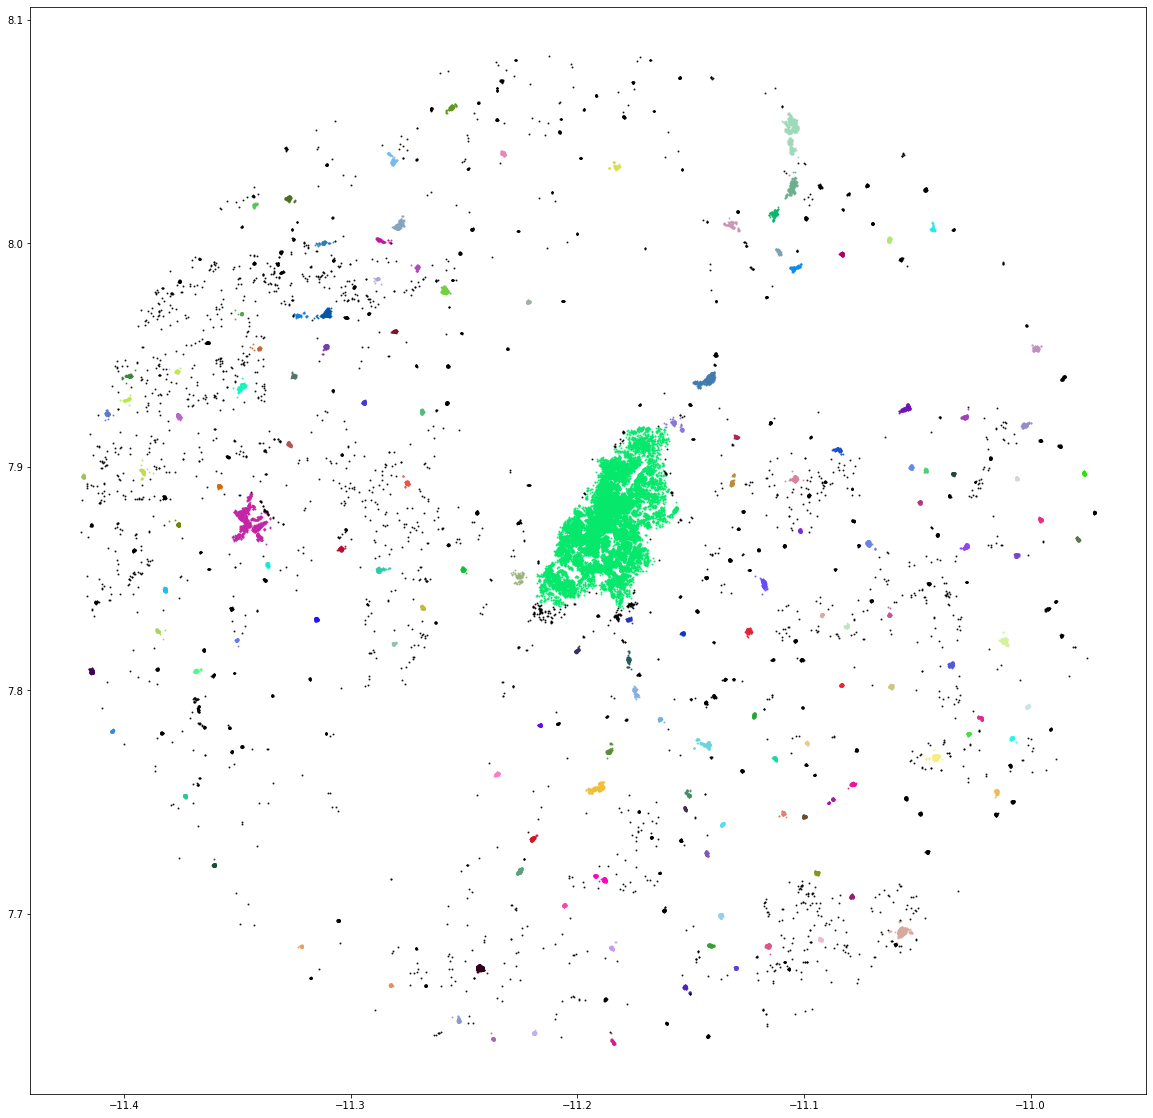

In [8]:
# Compute DBSCAN
clust = DBSCAN(eps=epsilon, min_samples=minsamples).fit(coords)
core_samples_mask = np.zeros_like(clust.labels_, dtype=bool)
core_samples_mask[clust.core_sample_indices_] = True
labelsF = clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labelsF)) - (1 if -1 in labelsF else 0)
n_noise_ = list(labelsF).count(-1)

# See how many houses in each cluster. -1 = outlier
(unique, counts) = np.unique(labelsF, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

plt.figure(figsize=(20, 20))
colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m']
colors = list(range(0,len(unique)))

for i in range(len(colors)):
    colors[i]=list(np.random.choice(range(255),size=3)/255)

colors=np.array(colors)


labels = labelsF
for klass, color in zip(range(0, len(unique)+1), colors): #double iteration simultaneously 
    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=1, alpha=0.8) #select only some points in cluster

# plot outliers
plt.scatter(x=coords[clust.labels_ == -1, 0], y=coords[clust.labels_ == -1, 1],color='k', s=1, alpha=0.8)

df = pd.DataFrame(coords)
df['Class'] = labelsF

#Find centroid
centroid= ([[0 for x in range(2)] for y in range(klass-1)]) 

for i in range(klass-1):
    centroid[i][0]=np.average(df[df["Class"]==i][0]) #x-coordinates
    centroid[i][1]=np.average(df[df["Class"]==i][1]) #y-coordinates

    centroid=np.array(centroid)

print(f"Area containing of {len(centroid)+1} clusters:")
clust.labels_=labelsF

In [9]:
dfg = pd.DataFrame(columns = ['Point', 'Cluster', 'Settlement type'])#'Cluster Number',                 

num_of_clusters = len(unique) - 1
settlement = 'Village'
for cluster in range(0, num_of_clusters):
    for coord in coords[labels == cluster]:
        x = coord[0]
        y = coord[1]
        point = Point(x,y)
        if frequencies[cluster + 1, 1] >= citypop:
            settlement = 'City'
        elif frequencies[cluster + 1, 1] >= minsamples and frequencies[cluster + 1, 1] < citypop:
            settlement = 'Village'
        entry = {'Point' : point, 'Cluster' : cluster, 'Settlement type': settlement}
        dfg = dfg.append(entry, ignore_index = True)
clusteredhomes1 = gp.GeoDataFrame(dfg, geometry = 'Point')
clusteredhomes1.to_file('villages.shp')

C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\micae\AppData\Local\Temp/ipykernel_3040/865475019.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clusteredhomes1.to_file('villages.shp')


In [10]:
dfg = pd.DataFrame(columns = ['Point', 'Cluster', 'Settlement type'])#'Cluster Number',                 

settlement = 'Independent Home'
for coord in coords[labels == -1]:
    x = coord[0]
    y = coord[1]
    point = Point(x,y)
    entry = {'Point' : point, 'Cluster' : cluster, 'Settlement type': settlement}
    dfg = dfg.append(entry, ignore_index = True)
clusteredhomes = gp.GeoDataFrame(dfg, geometry = 'Point')
clusteredhomes.to_file('outliers.shp')

C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\micae\AppData\Local\Temp/ipykernel_3040/2464488281.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clusteredhomes.to_file('outliers.shp')


In [11]:
#clusteredhomes1

In [12]:
#clusteredhomes

Number of nodes (buildings) in the graph:  140
Number of edges in the minimum spanning tree:  139
Total distance of minimum spanning tree (in km):  363.0449088789875


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


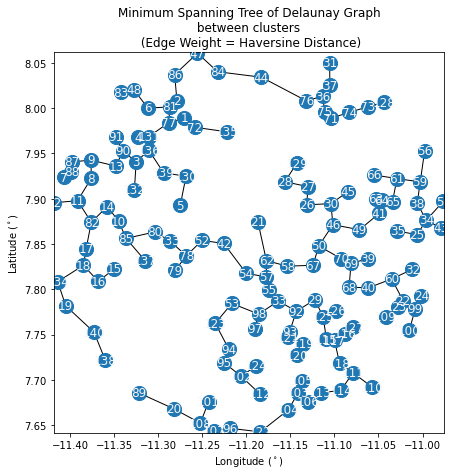

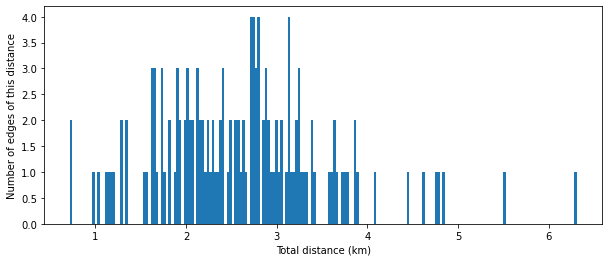

In [13]:
#Plot centroids 
klass
ngroups,tdists,tweight=makeatree(centroid,1,-2) #-2 means transmission line, this call is only for transmission

In [14]:
df3 = pd.DataFrame({
    "Cluster Group" : labels
    })

In [15]:
df3

Cluster Group
0                 -1
1                 -1
2                 -1
3                 -1
4                 -1
...              ...
43745             47
43746             47
43747             47
43748             47
43749            109

[43750 rows x 1 columns]

Cluster Details:
Number of nodes (buildings) in the graph:  92
Number of edges in the minimum spanning tree:  91
Total distance of minimum spanning tree (in km):  1.4396672904035663


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


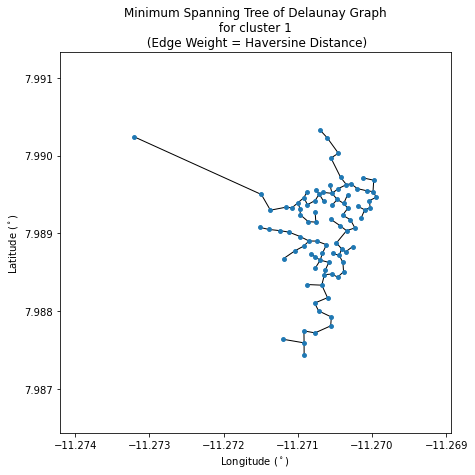

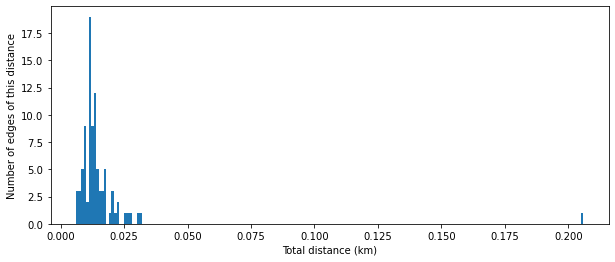

Number of nodes (buildings) in the graph:  228
Number of edges in the minimum spanning tree:  227
Total distance of minimum spanning tree (in km):  4.074730483102849


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


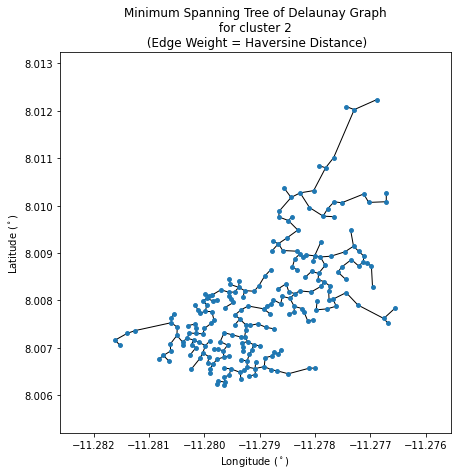

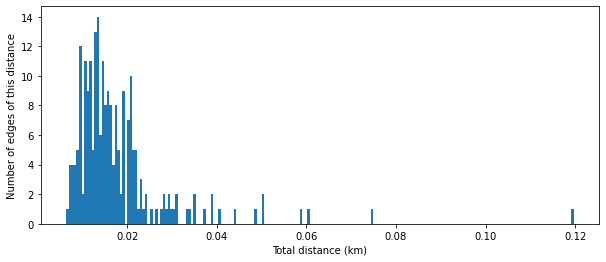

Number of nodes (buildings) in the graph:  68
Number of edges in the minimum spanning tree:  67
Total distance of minimum spanning tree (in km):  1.3052848892088198


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


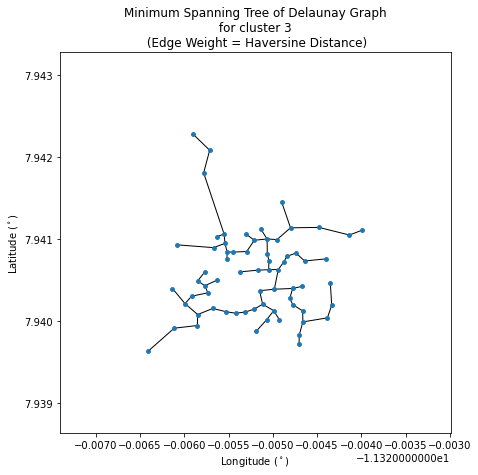

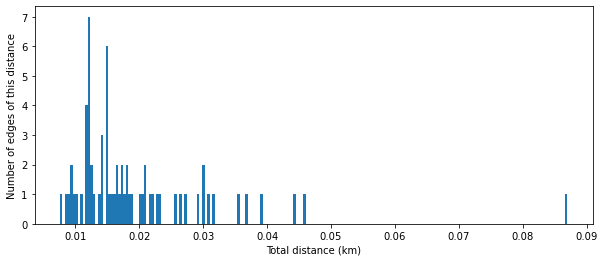

Number of nodes (buildings) in the graph:  50
Number of edges in the minimum spanning tree:  49
Total distance of minimum spanning tree (in km):  1.446499420259425


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


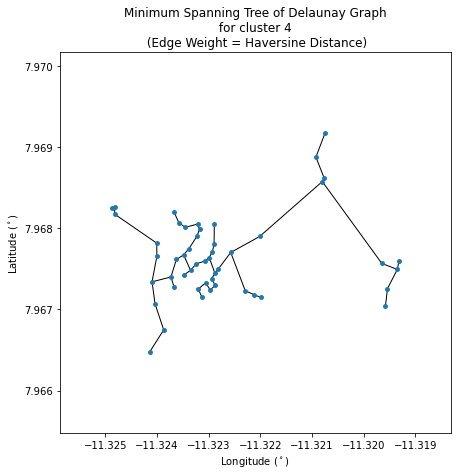

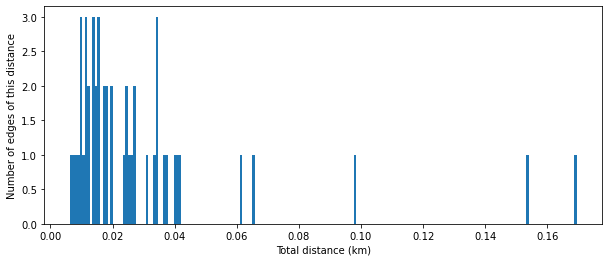

Number of nodes (buildings) in the graph:  117
Number of edges in the minimum spanning tree:  116
Total distance of minimum spanning tree (in km):  1.8480146610034995


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


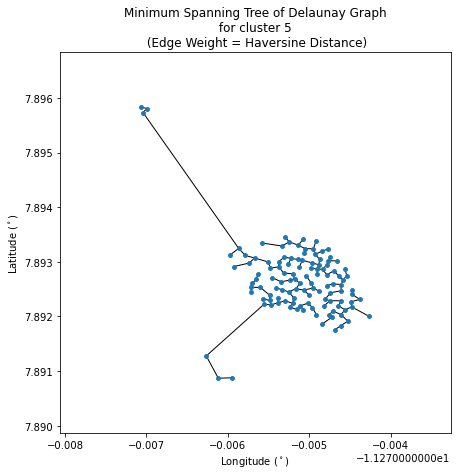

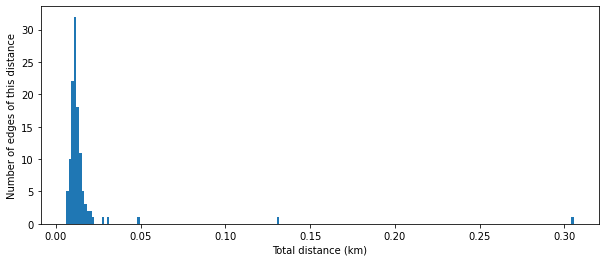

Number of nodes (buildings) in the graph:  66
Number of edges in the minimum spanning tree:  65
Total distance of minimum spanning tree (in km):  1.9250188196731668


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


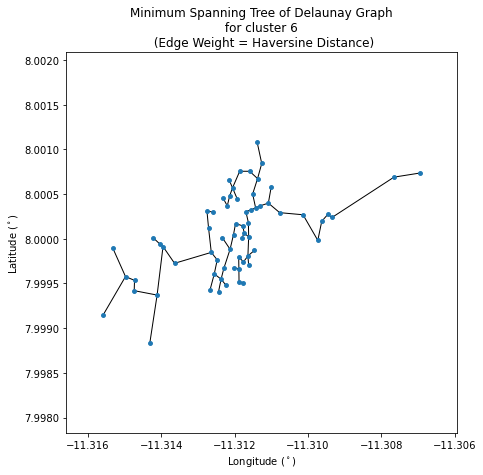

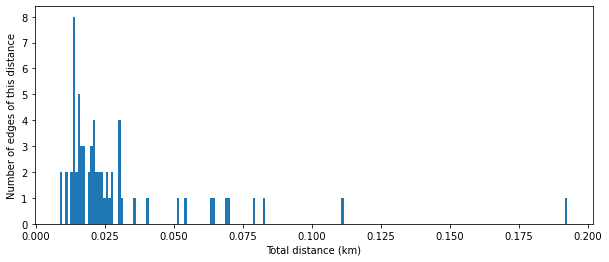

Number of nodes (buildings) in the graph:  103
Number of edges in the minimum spanning tree:  102
Total distance of minimum spanning tree (in km):  1.7616158401312227


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


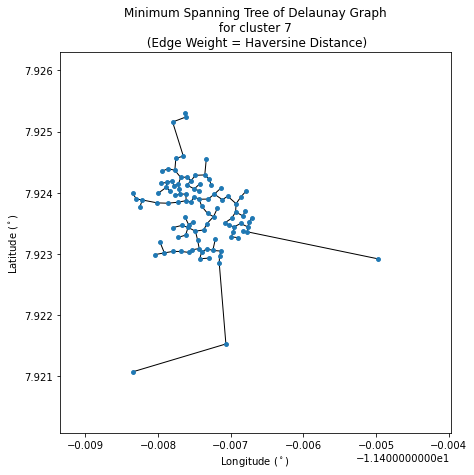

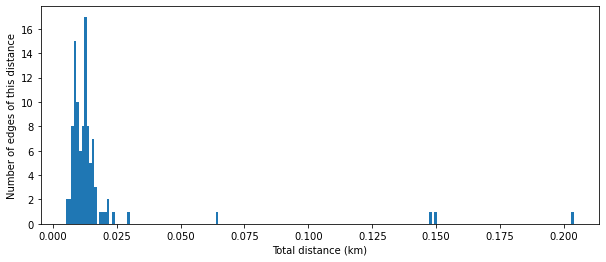

Number of nodes (buildings) in the graph:  144
Number of edges in the minimum spanning tree:  143
Total distance of minimum spanning tree (in km):  1.697724684048051


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


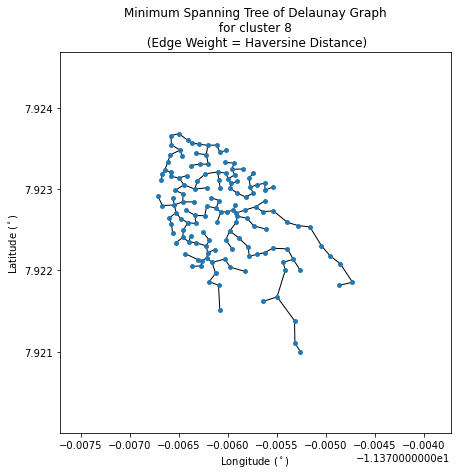

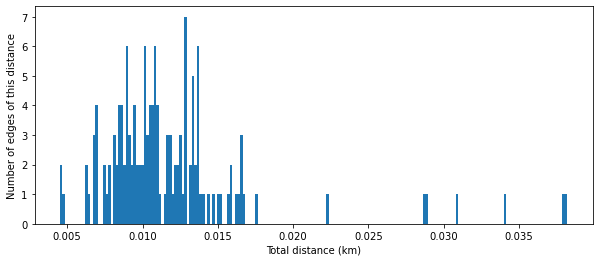

Number of nodes (buildings) in the graph:  68
Number of edges in the minimum spanning tree:  67
Total distance of minimum spanning tree (in km):  1.2412510166115267


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


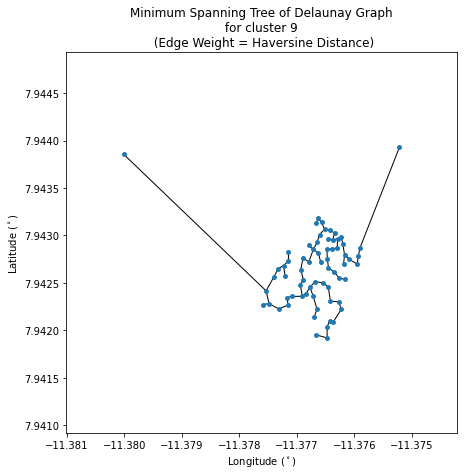

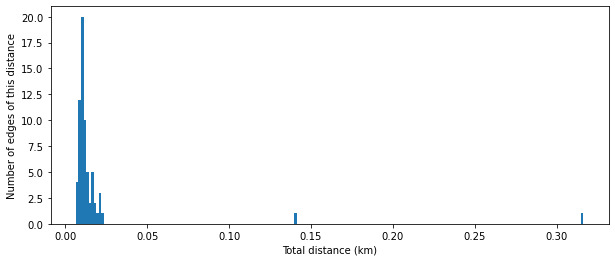

Number of nodes (buildings) in the graph:  1093
Number of edges in the minimum spanning tree:  1092
Total distance of minimum spanning tree (in km):  23.949436975302476


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


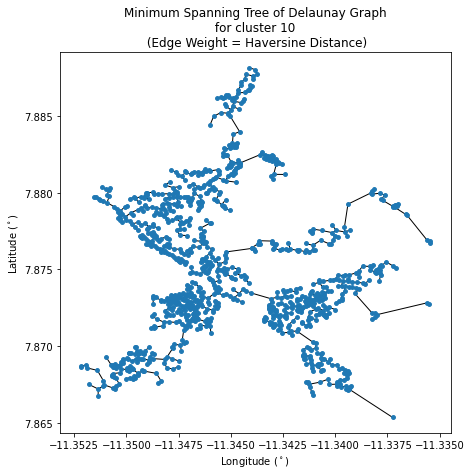

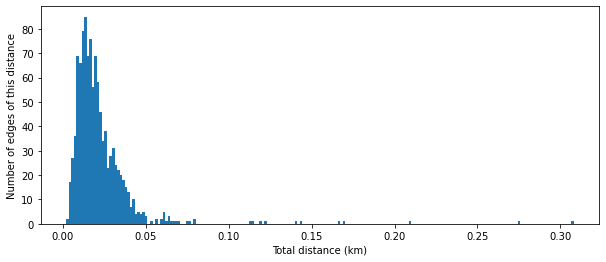

Number of nodes (buildings) in the graph:  133
Number of edges in the minimum spanning tree:  132
Total distance of minimum spanning tree (in km):  2.7320236223082794


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


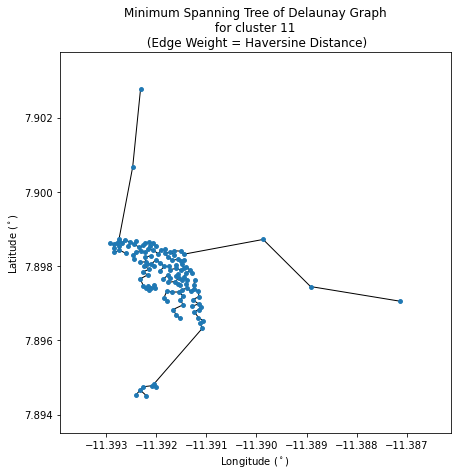

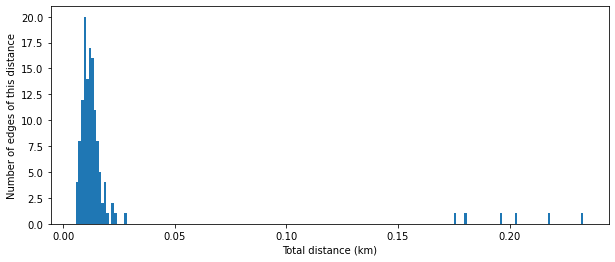

Number of nodes (buildings) in the graph:  64
Number of edges in the minimum spanning tree:  63
Total distance of minimum spanning tree (in km):  1.0658005017439227


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


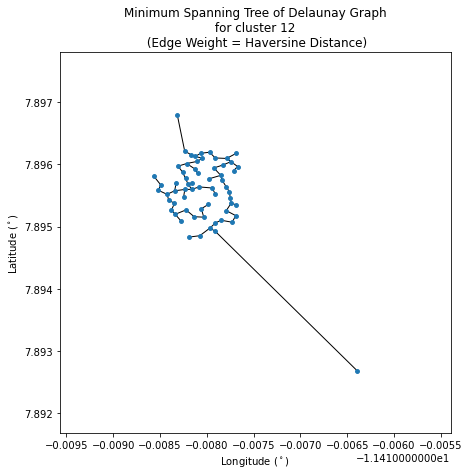

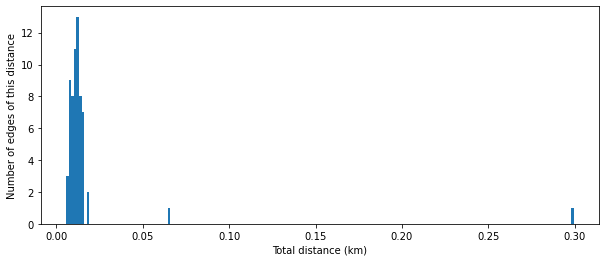

Number of nodes (buildings) in the graph:  191
Number of edges in the minimum spanning tree:  190
Total distance of minimum spanning tree (in km):  3.5517438208176344


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


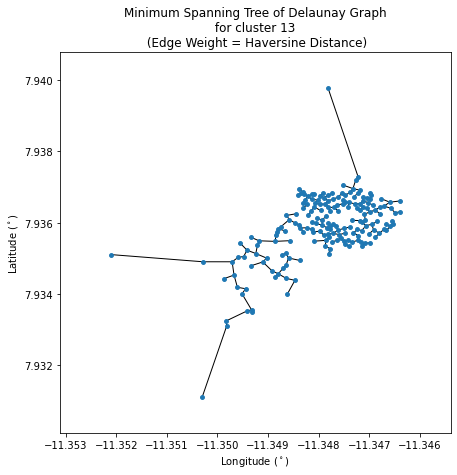

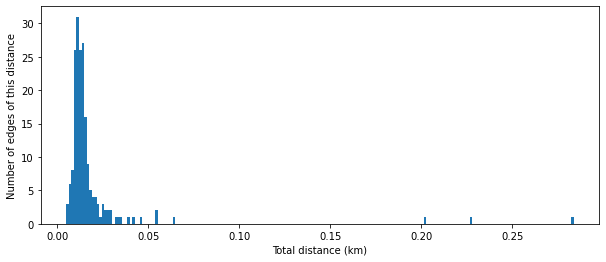

Number of nodes (buildings) in the graph:  81
Number of edges in the minimum spanning tree:  80
Total distance of minimum spanning tree (in km):  1.1307094811174165


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


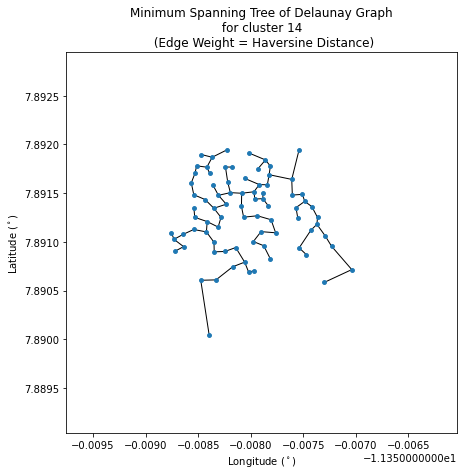

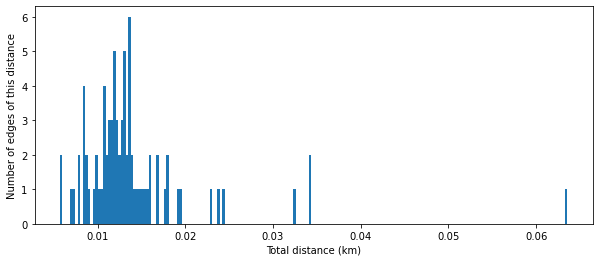

Number of nodes (buildings) in the graph:  54
Number of edges in the minimum spanning tree:  53
Total distance of minimum spanning tree (in km):  0.8033648499791665


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


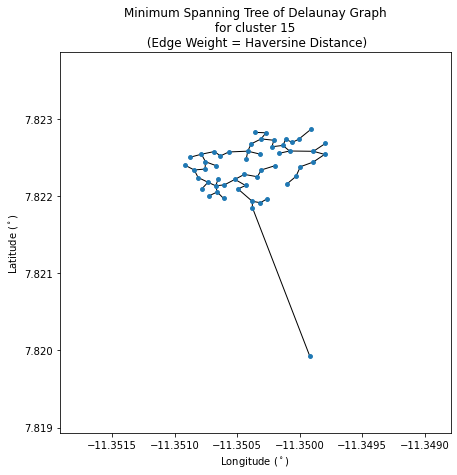

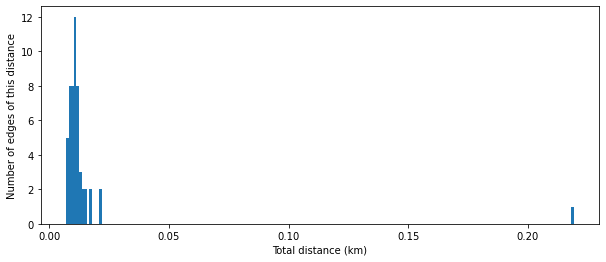

Number of nodes (buildings) in the graph:  82
Number of edges in the minimum spanning tree:  81
Total distance of minimum spanning tree (in km):  1.2106785313160924


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


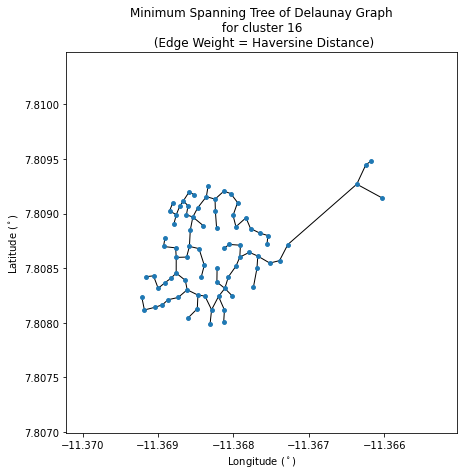

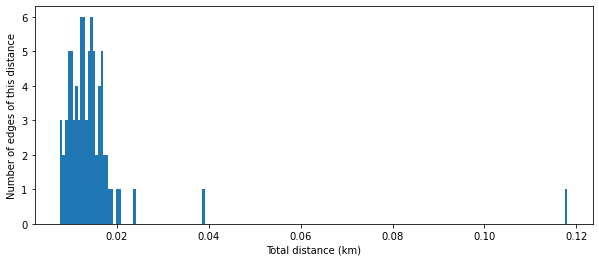

Number of nodes (buildings) in the graph:  111
Number of edges in the minimum spanning tree:  110
Total distance of minimum spanning tree (in km):  1.2030392548229167


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


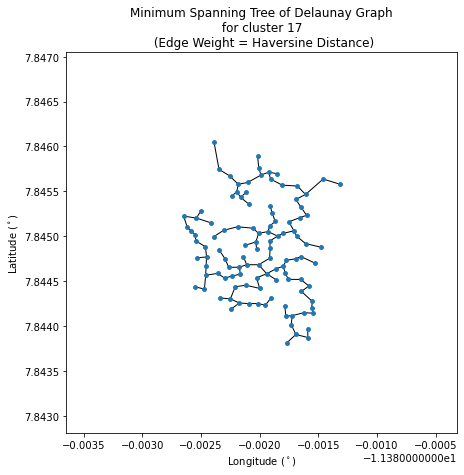

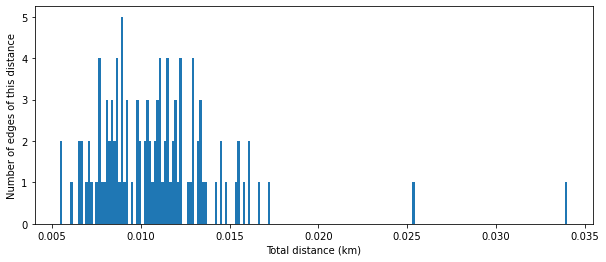

Number of nodes (buildings) in the graph:  63
Number of edges in the minimum spanning tree:  62
Total distance of minimum spanning tree (in km):  1.4913571132433059


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


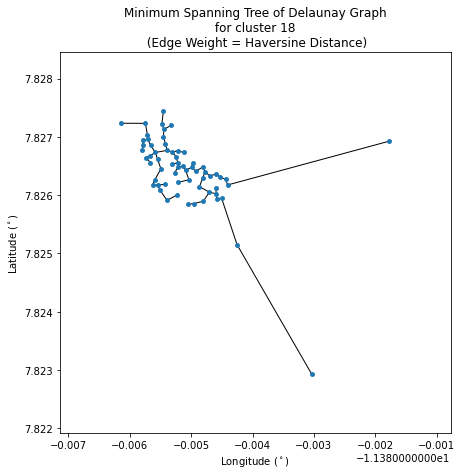

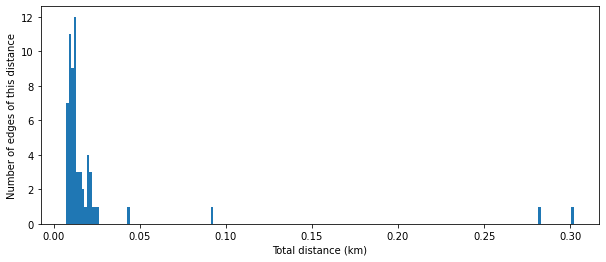

Number of nodes (buildings) in the graph:  59
Number of edges in the minimum spanning tree:  58
Total distance of minimum spanning tree (in km):  0.674594480384103


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


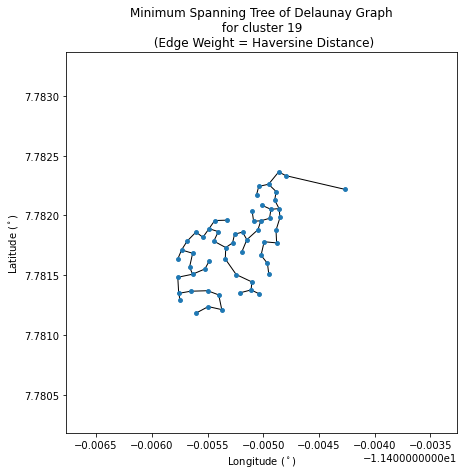

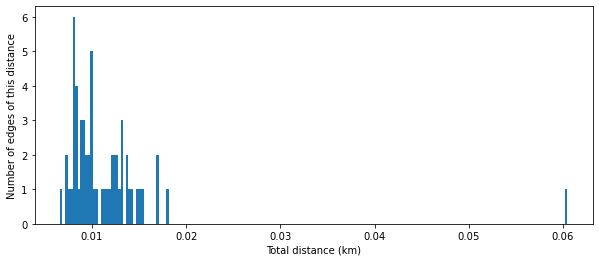

Number of nodes (buildings) in the graph:  60
Number of edges in the minimum spanning tree:  59
Total distance of minimum spanning tree (in km):  0.6573447687677125


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


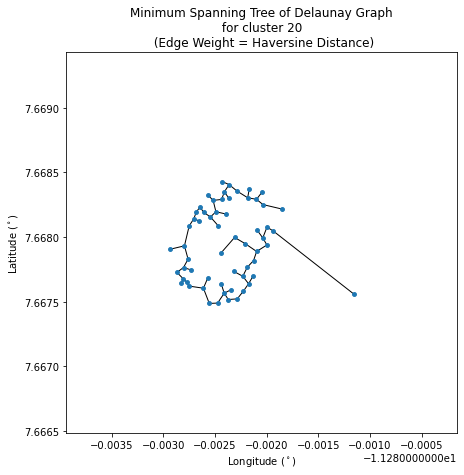

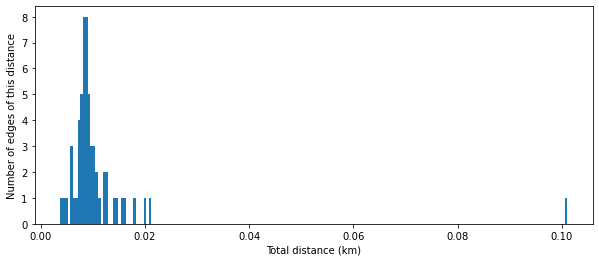

Number of nodes (buildings) in the graph:  21411
Number of edges in the minimum spanning tree:  21410
Total distance of minimum spanning tree (in km):  453.0060292709008


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


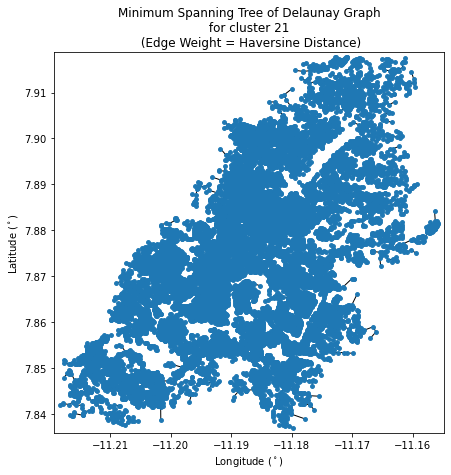

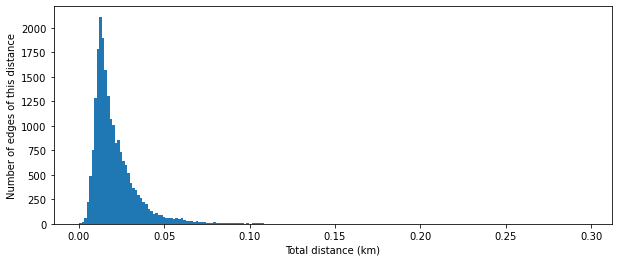

Number of nodes (buildings) in the graph:  62
Number of edges in the minimum spanning tree:  61
Total distance of minimum spanning tree (in km):  0.8975160275853594


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


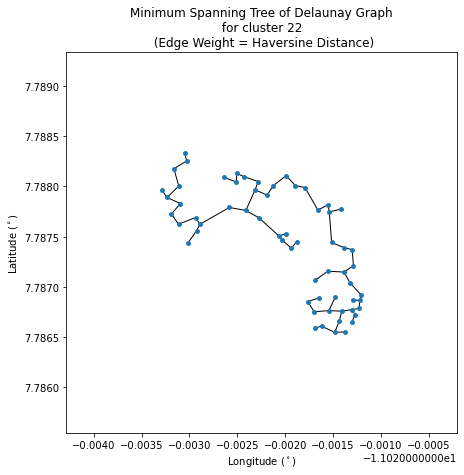

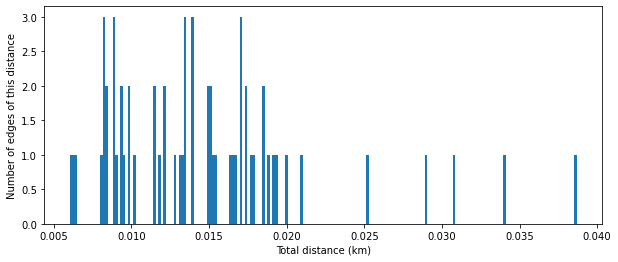

Number of nodes (buildings) in the graph:  59
Number of edges in the minimum spanning tree:  58
Total distance of minimum spanning tree (in km):  0.7550169309163958


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


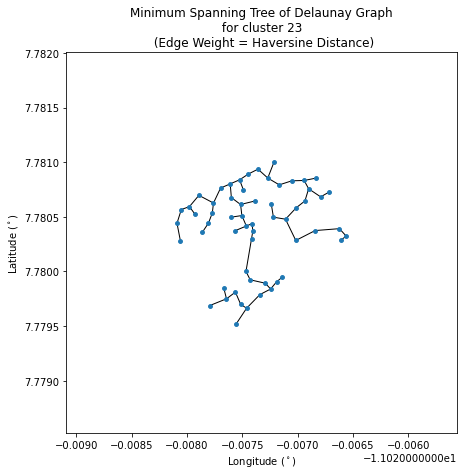

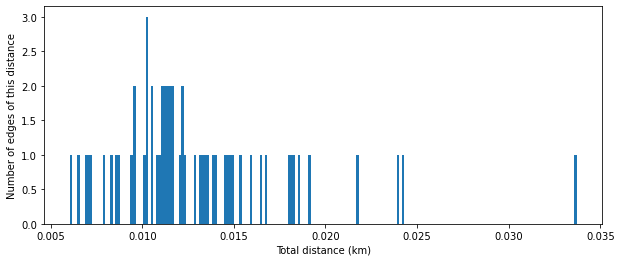

Number of nodes (buildings) in the graph:  69
Number of edges in the minimum spanning tree:  68
Total distance of minimum spanning tree (in km):  1.0064669979583554


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


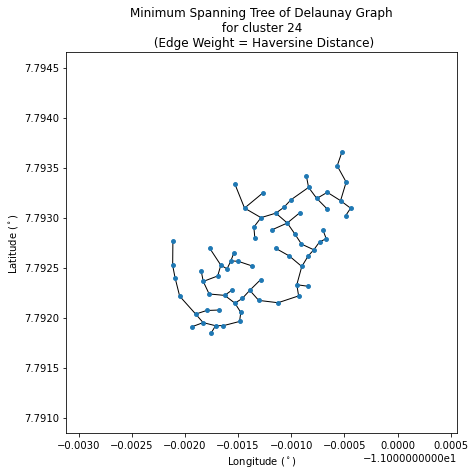

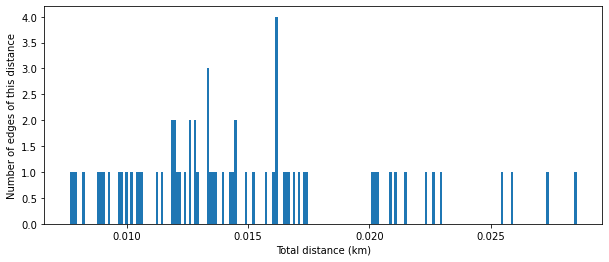

Number of nodes (buildings) in the graph:  80
Number of edges in the minimum spanning tree:  79
Total distance of minimum spanning tree (in km):  1.0980857583559875


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


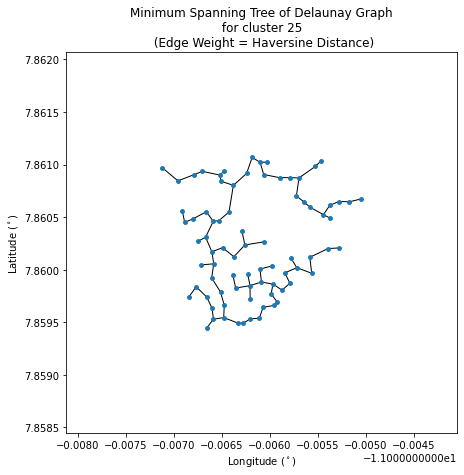

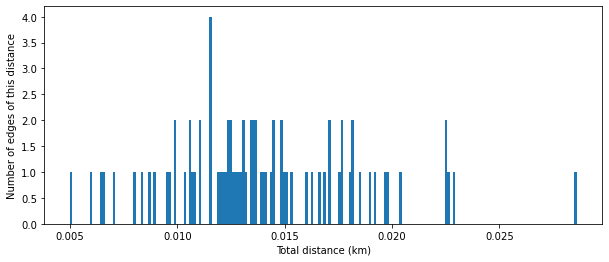

Number of nodes (buildings) in the graph:  86
Number of edges in the minimum spanning tree:  85
Total distance of minimum spanning tree (in km):  1.581997729616224


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


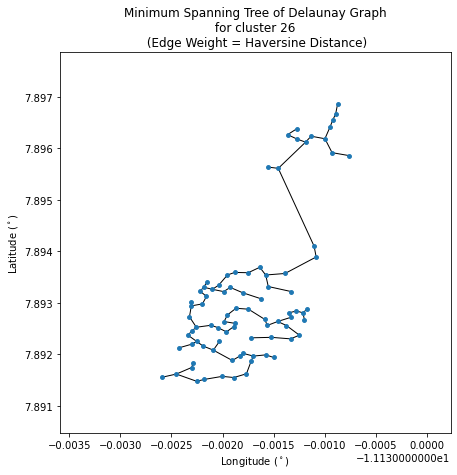

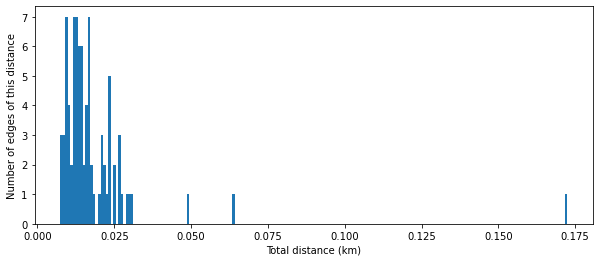

Number of nodes (buildings) in the graph:  60
Number of edges in the minimum spanning tree:  59
Total distance of minimum spanning tree (in km):  0.8547117369824209


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


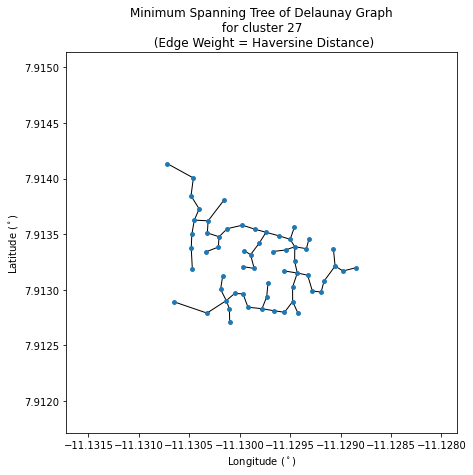

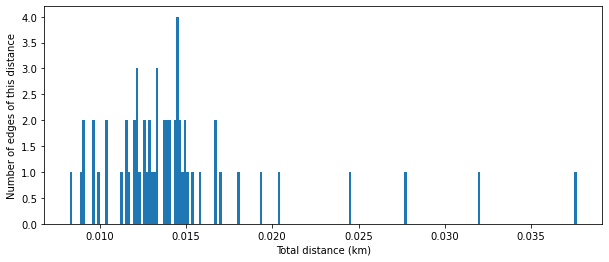

Number of nodes (buildings) in the graph:  120
Number of edges in the minimum spanning tree:  119
Total distance of minimum spanning tree (in km):  3.3388136156608392


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


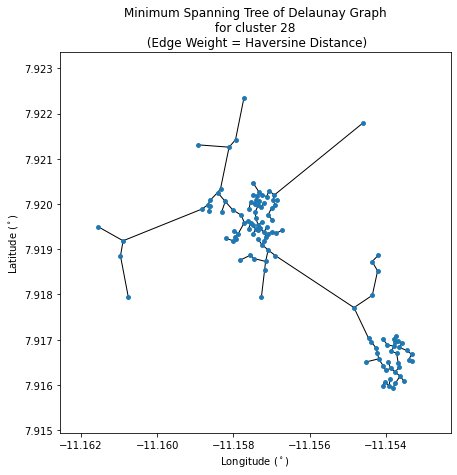

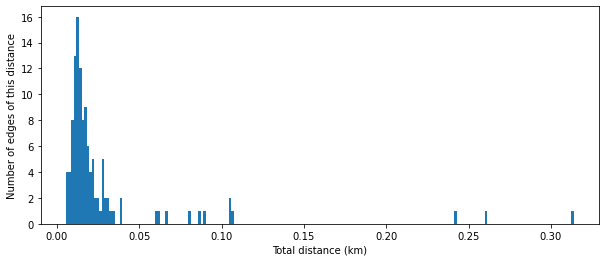

Number of nodes (buildings) in the graph:  65
Number of edges in the minimum spanning tree:  64
Total distance of minimum spanning tree (in km):  0.9468186133903005


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


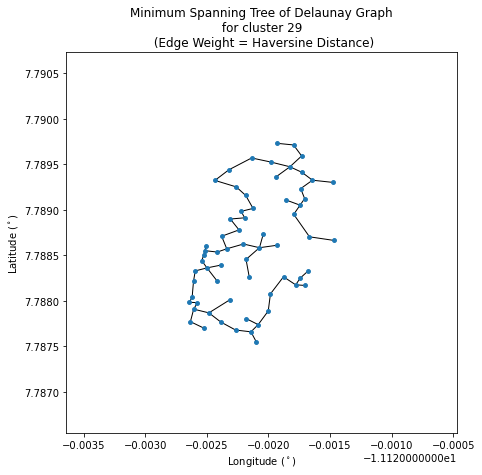

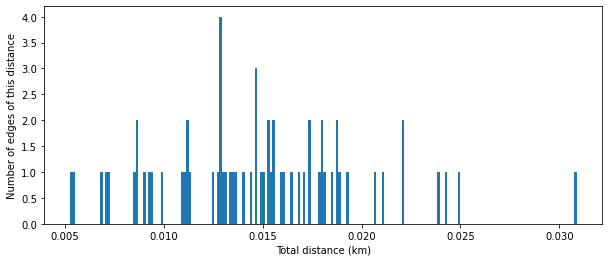

Number of nodes (buildings) in the graph:  188
Number of edges in the minimum spanning tree:  187
Total distance of minimum spanning tree (in km):  3.112179914546215


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


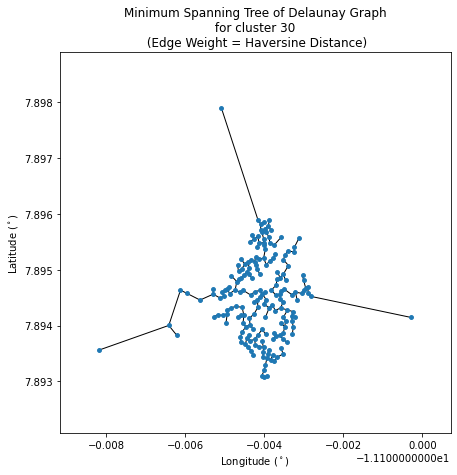

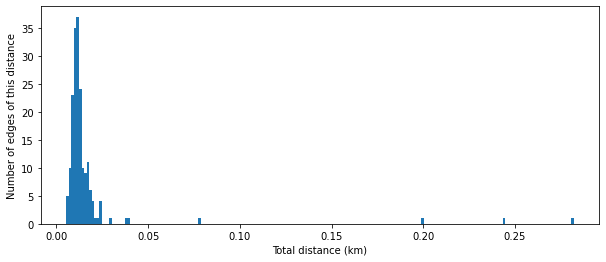

Number of nodes (buildings) in the graph:  508
Number of edges in the minimum spanning tree:  507
Total distance of minimum spanning tree (in km):  12.143105958851583


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


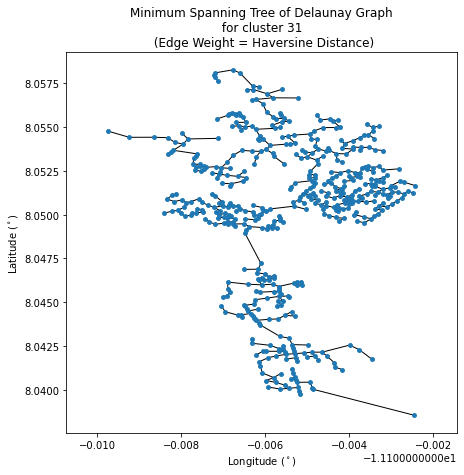

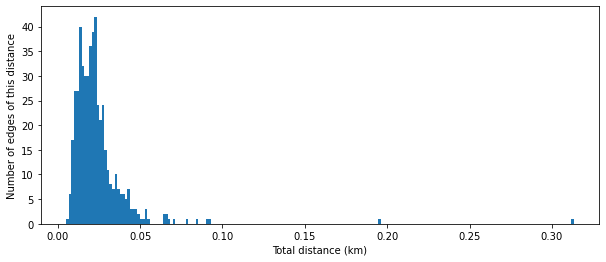

Number of nodes (buildings) in the graph:  190
Number of edges in the minimum spanning tree:  189
Total distance of minimum spanning tree (in km):  3.2817466530663033


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


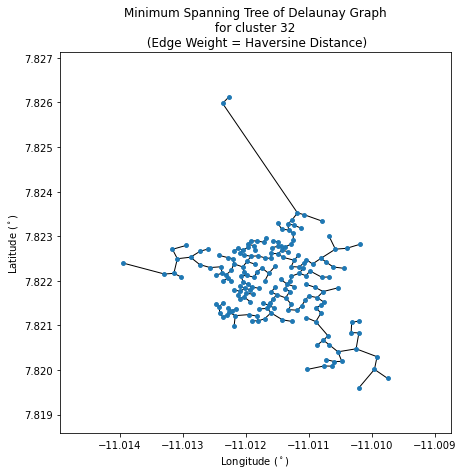

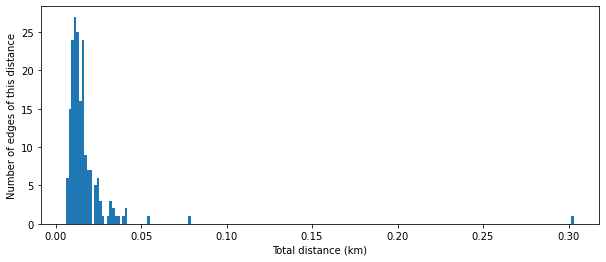

Number of nodes (buildings) in the graph:  54
Number of edges in the minimum spanning tree:  53
Total distance of minimum spanning tree (in km):  0.9328349886752034


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


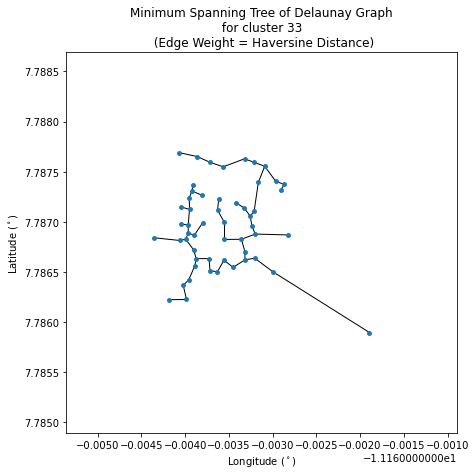

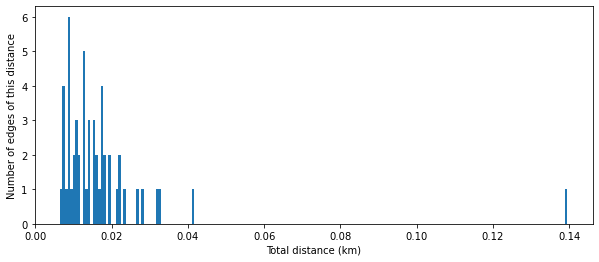

Number of nodes (buildings) in the graph:  92
Number of edges in the minimum spanning tree:  91
Total distance of minimum spanning tree (in km):  1.0487307065953504


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


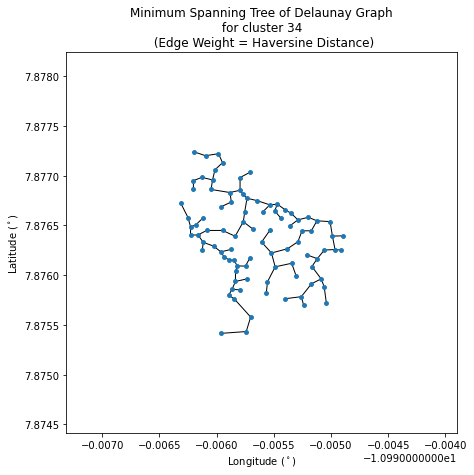

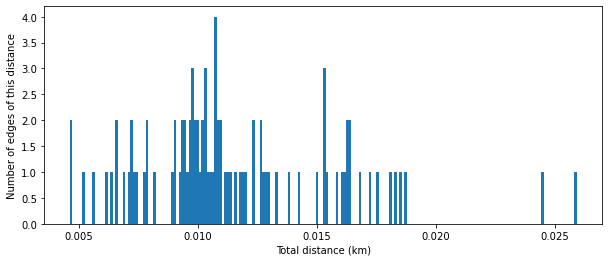

Number of nodes (buildings) in the graph:  142
Number of edges in the minimum spanning tree:  141
Total distance of minimum spanning tree (in km):  1.7691214847935899


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


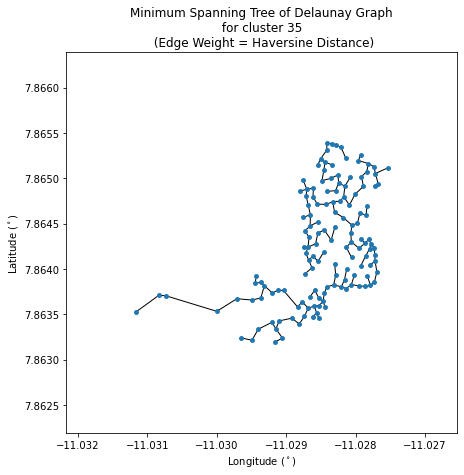

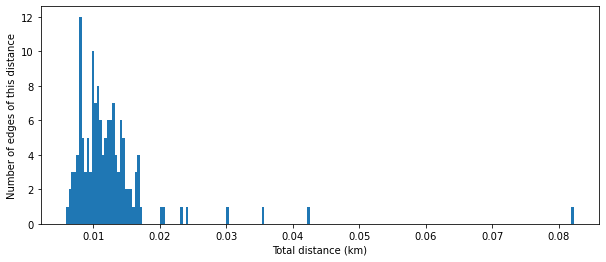

Number of nodes (buildings) in the graph:  106
Number of edges in the minimum spanning tree:  105
Total distance of minimum spanning tree (in km):  2.5969909998269025


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


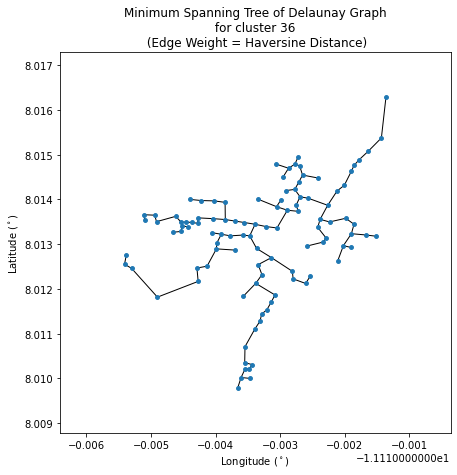

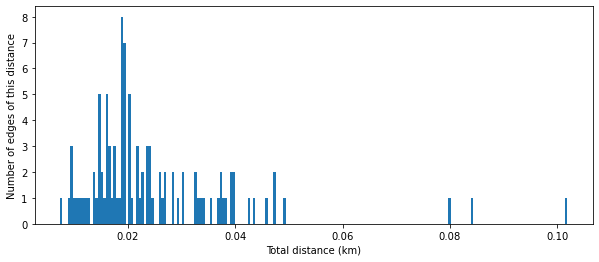

Number of nodes (buildings) in the graph:  199
Number of edges in the minimum spanning tree:  198
Total distance of minimum spanning tree (in km):  5.564381096850454


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


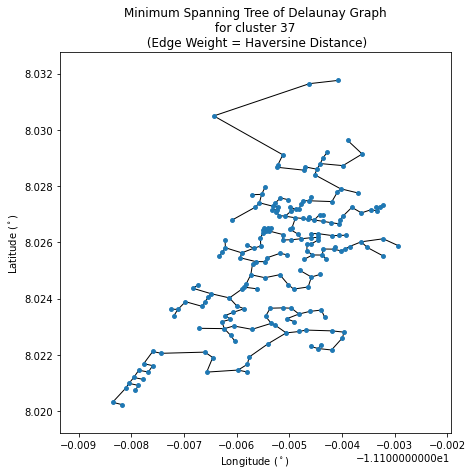

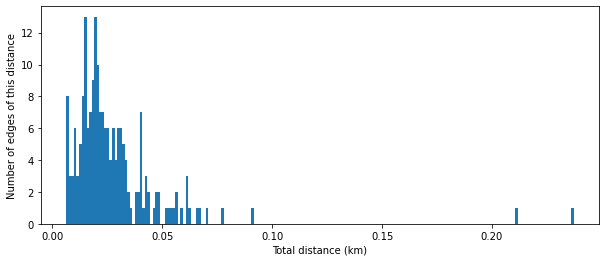

Number of nodes (buildings) in the graph:  71
Number of edges in the minimum spanning tree:  70
Total distance of minimum spanning tree (in km):  0.8258470378748791


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


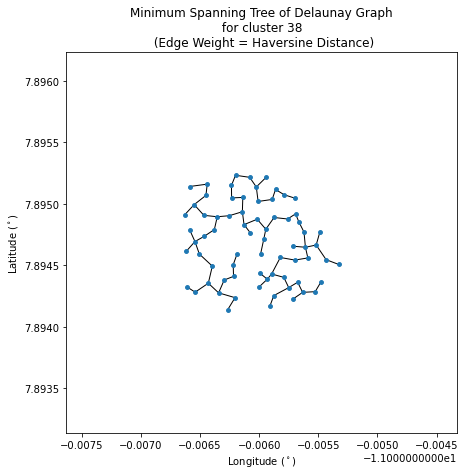

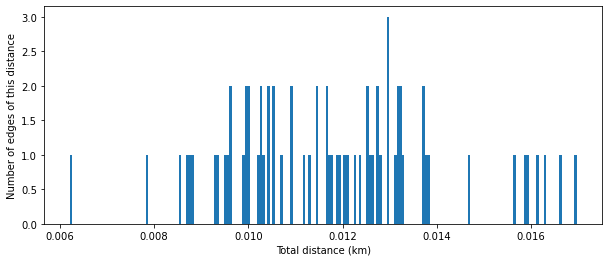

Number of nodes (buildings) in the graph:  76
Number of edges in the minimum spanning tree:  75
Total distance of minimum spanning tree (in km):  1.1518693811738485


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


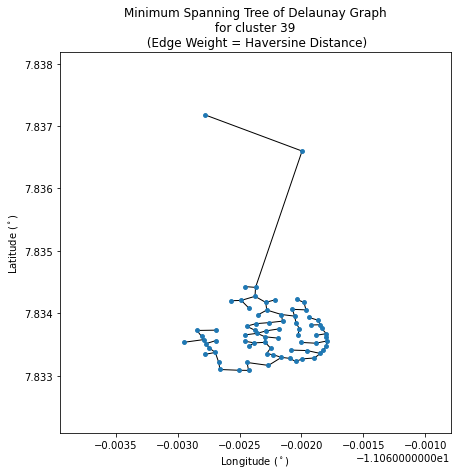

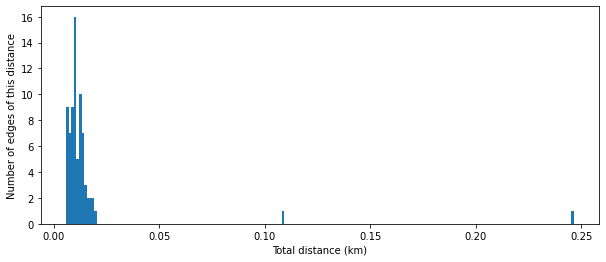

Number of nodes (buildings) in the graph:  108
Number of edges in the minimum spanning tree:  107
Total distance of minimum spanning tree (in km):  1.3004353147521257


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


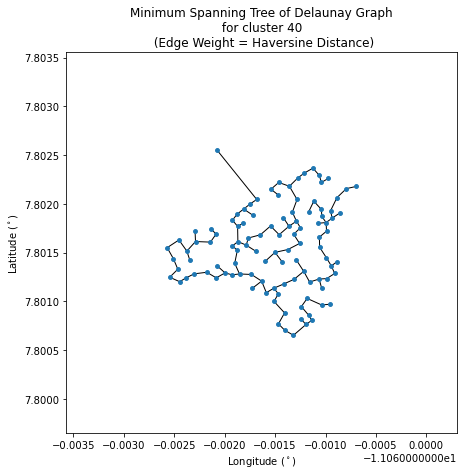

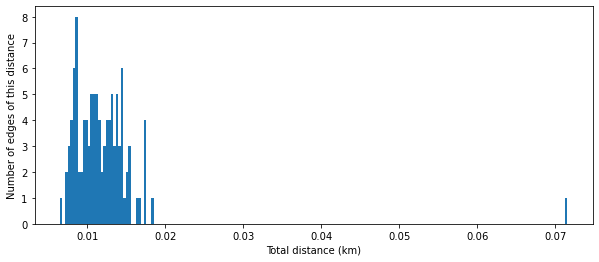

Number of nodes (buildings) in the graph:  54
Number of edges in the minimum spanning tree:  53
Total distance of minimum spanning tree (in km):  0.866310954576117


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


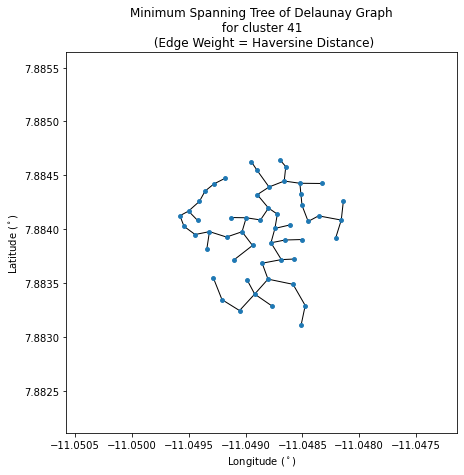

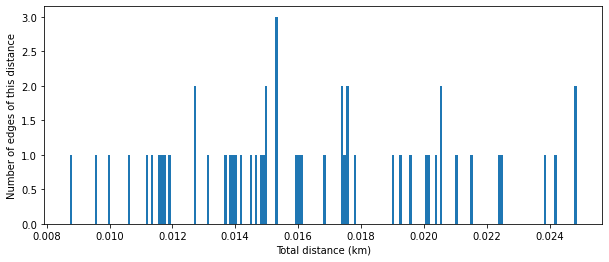

Number of nodes (buildings) in the graph:  92
Number of edges in the minimum spanning tree:  91
Total distance of minimum spanning tree (in km):  3.273945252402288


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


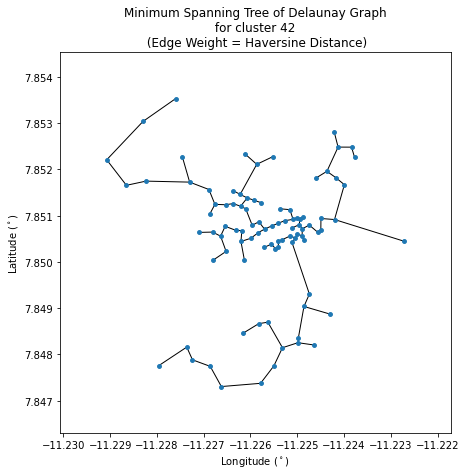

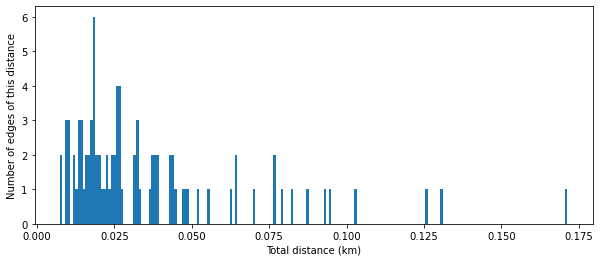

Number of nodes (buildings) in the graph:  66
Number of edges in the minimum spanning tree:  65
Total distance of minimum spanning tree (in km):  0.8109304870577267


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


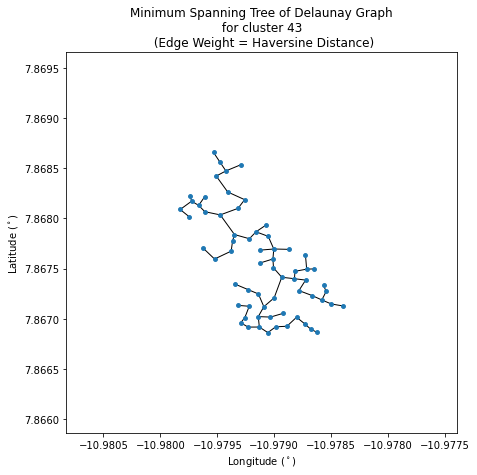

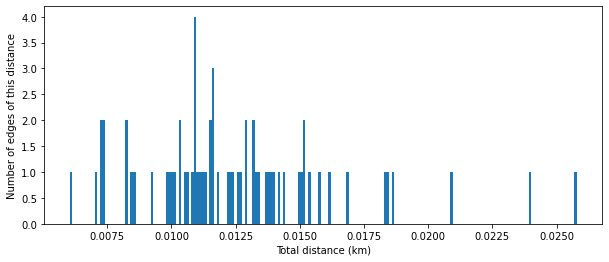

Number of nodes (buildings) in the graph:  131
Number of edges in the minimum spanning tree:  130
Total distance of minimum spanning tree (in km):  2.1996955551055946


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


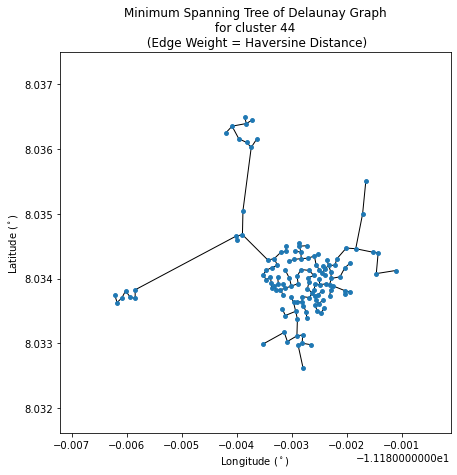

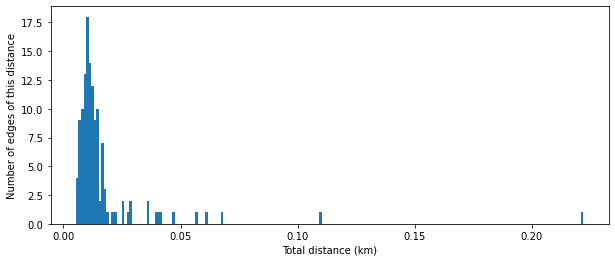

Number of nodes (buildings) in the graph:  93
Number of edges in the minimum spanning tree:  92
Total distance of minimum spanning tree (in km):  1.6877269233583472


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


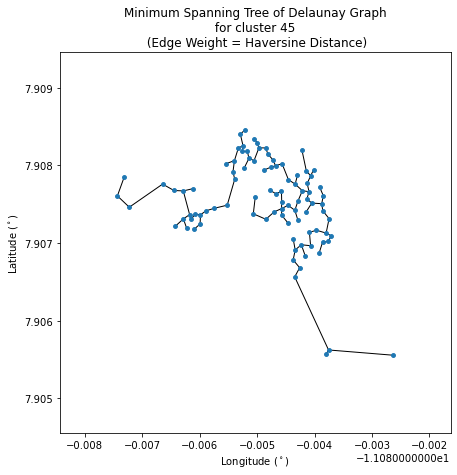

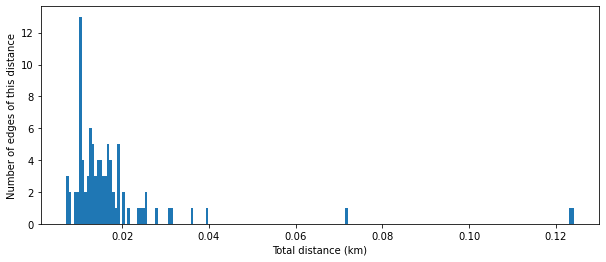

Number of nodes (buildings) in the graph:  70
Number of edges in the minimum spanning tree:  69
Total distance of minimum spanning tree (in km):  0.7444149837686096


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


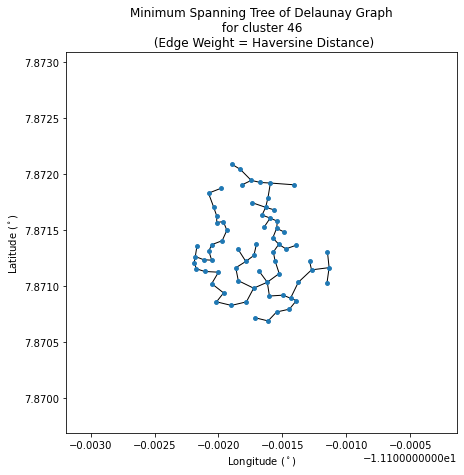

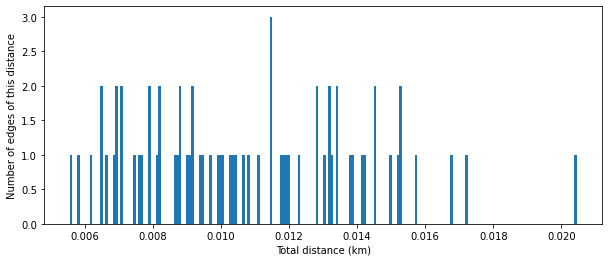

Number of nodes (buildings) in the graph:  135
Number of edges in the minimum spanning tree:  134
Total distance of minimum spanning tree (in km):  2.080921680646066


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


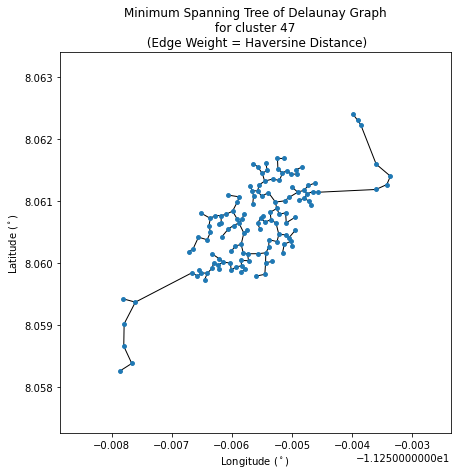

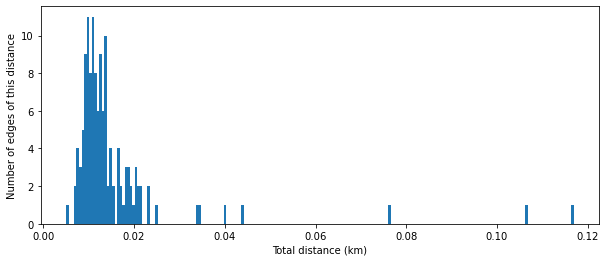

Number of nodes (buildings) in the graph:  139
Number of edges in the minimum spanning tree:  138
Total distance of minimum spanning tree (in km):  2.1039824571292423


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


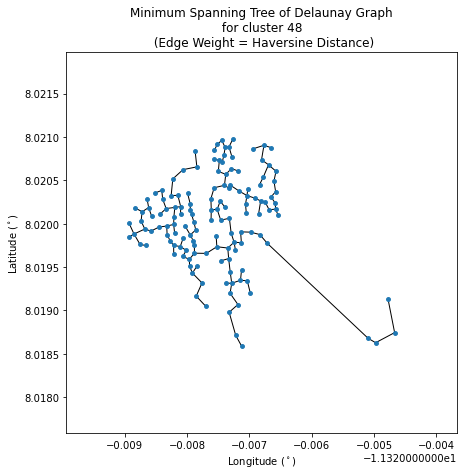

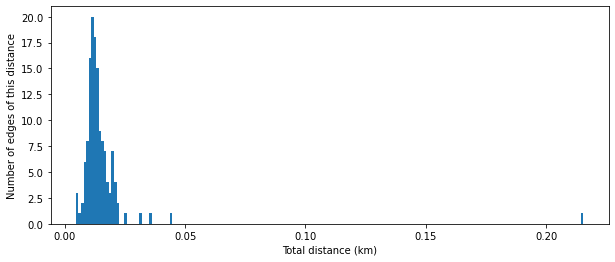

Number of nodes (buildings) in the graph:  157
Number of edges in the minimum spanning tree:  156
Total distance of minimum spanning tree (in km):  2.533466470484485


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


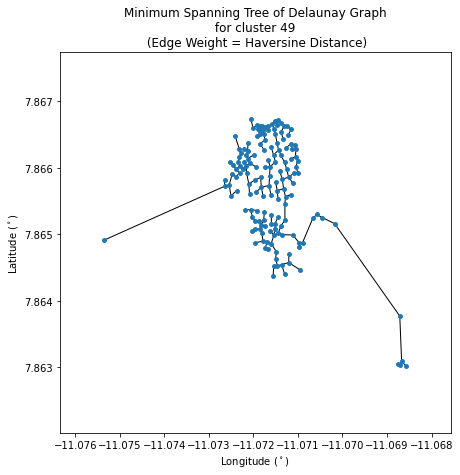

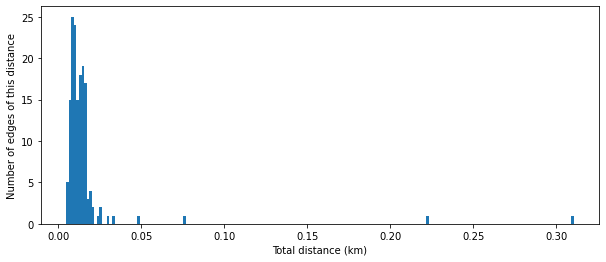

Number of nodes (buildings) in the graph:  183
Number of edges in the minimum spanning tree:  182
Total distance of minimum spanning tree (in km):  3.2650017525055897


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


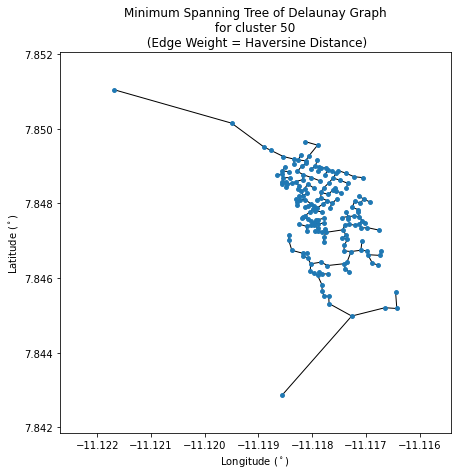

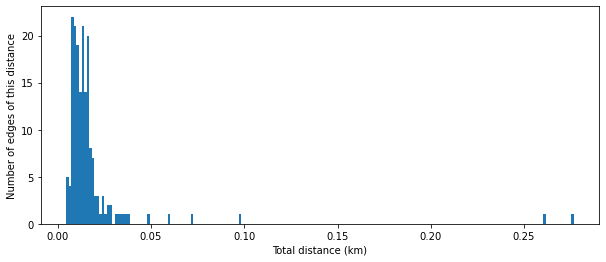

Number of nodes (buildings) in the graph:  80
Number of edges in the minimum spanning tree:  79
Total distance of minimum spanning tree (in km):  0.9425937161855448


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


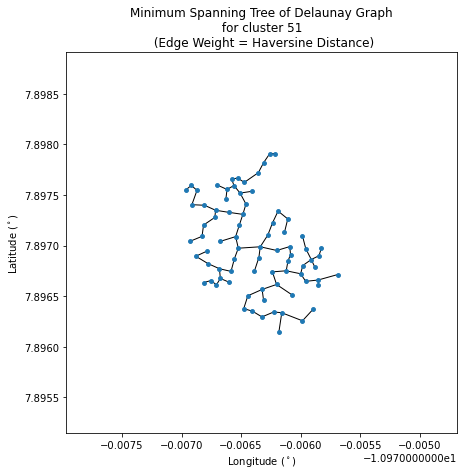

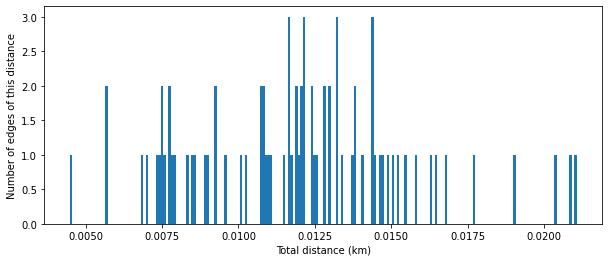

Number of nodes (buildings) in the graph:  82
Number of edges in the minimum spanning tree:  81
Total distance of minimum spanning tree (in km):  1.378756405155316


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


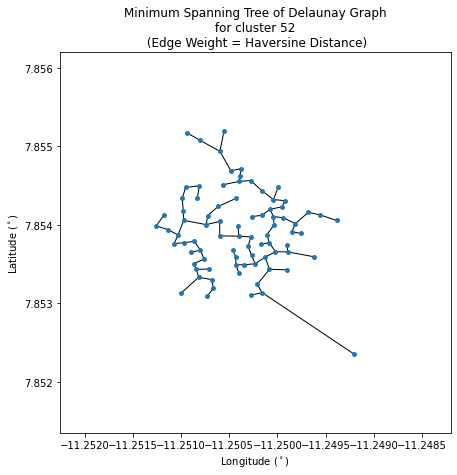

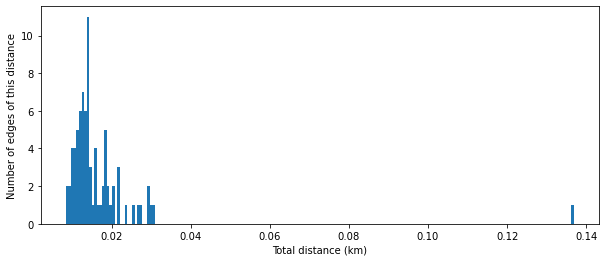

Number of nodes (buildings) in the graph:  71
Number of edges in the minimum spanning tree:  70
Total distance of minimum spanning tree (in km):  0.6878406068924202


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


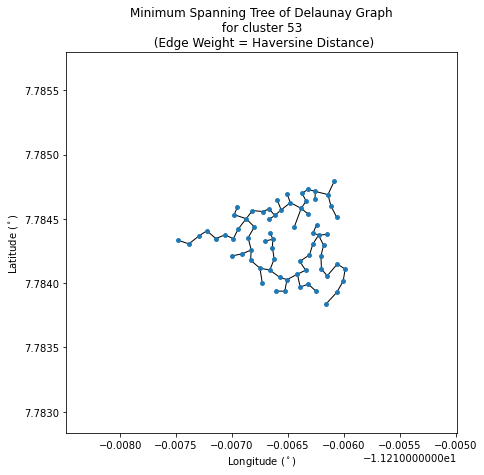

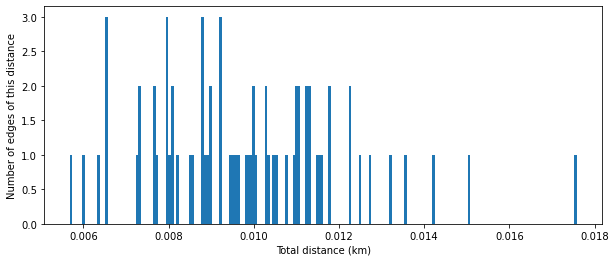

Number of nodes (buildings) in the graph:  75
Number of edges in the minimum spanning tree:  74
Total distance of minimum spanning tree (in km):  1.1767239400737355


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


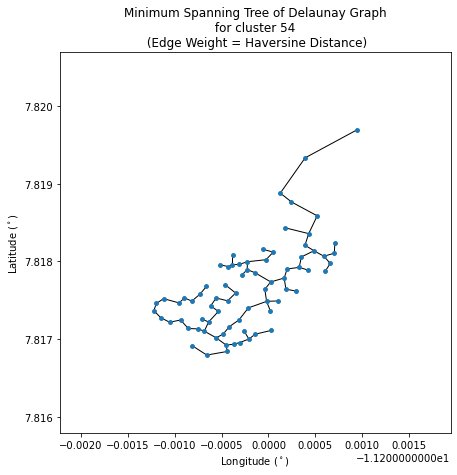

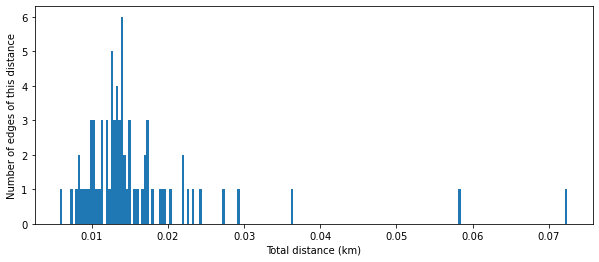

Number of nodes (buildings) in the graph:  94
Number of edges in the minimum spanning tree:  93
Total distance of minimum spanning tree (in km):  1.9515266003059262


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


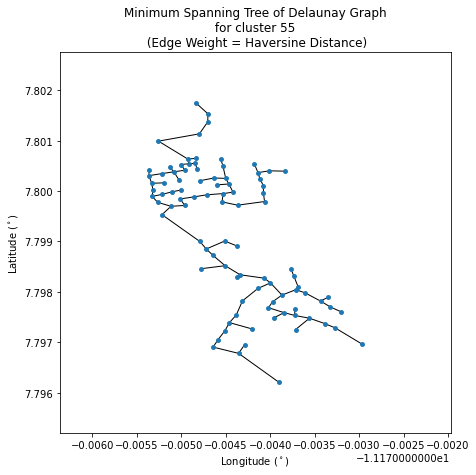

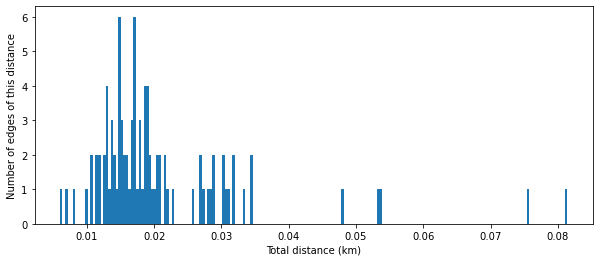

Number of nodes (buildings) in the graph:  91
Number of edges in the minimum spanning tree:  90
Total distance of minimum spanning tree (in km):  2.2123043712478405


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


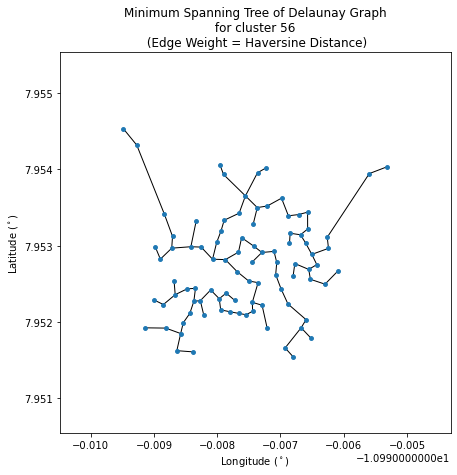

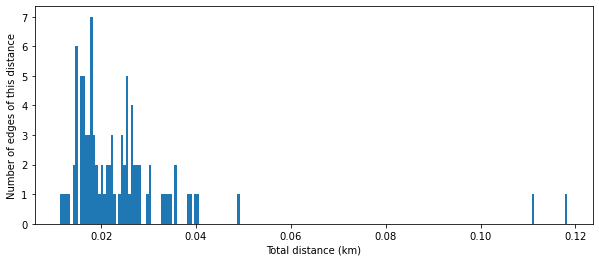

Number of nodes (buildings) in the graph:  79
Number of edges in the minimum spanning tree:  78
Total distance of minimum spanning tree (in km):  1.8542217688134481


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


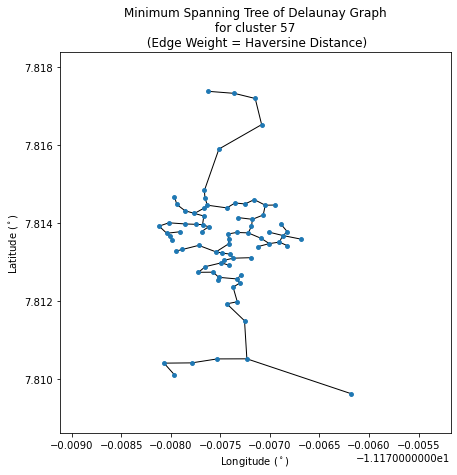

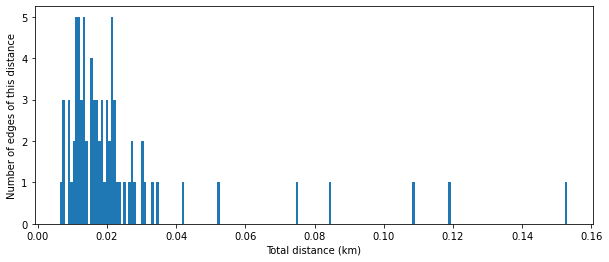

Number of nodes (buildings) in the graph:  63
Number of edges in the minimum spanning tree:  62
Total distance of minimum spanning tree (in km):  0.8687791191174358


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


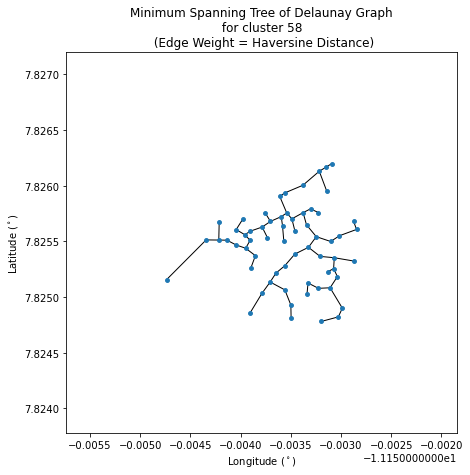

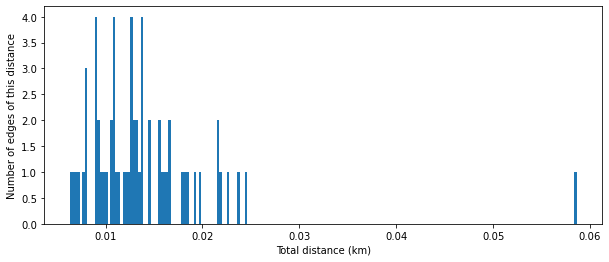

Number of nodes (buildings) in the graph:  118
Number of edges in the minimum spanning tree:  117
Total distance of minimum spanning tree (in km):  2.2467928321750246


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


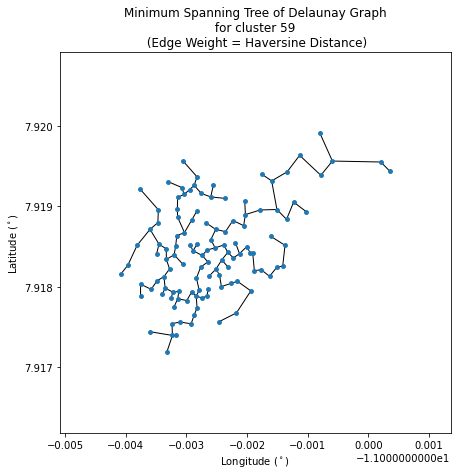

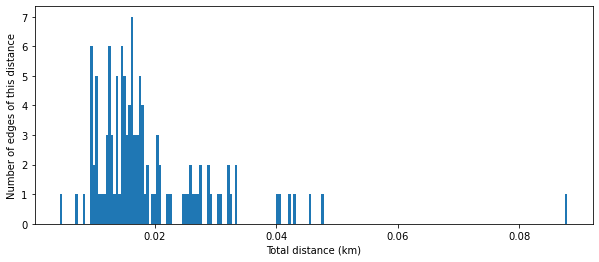

Number of nodes (buildings) in the graph:  140
Number of edges in the minimum spanning tree:  139
Total distance of minimum spanning tree (in km):  1.9158997293531015


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


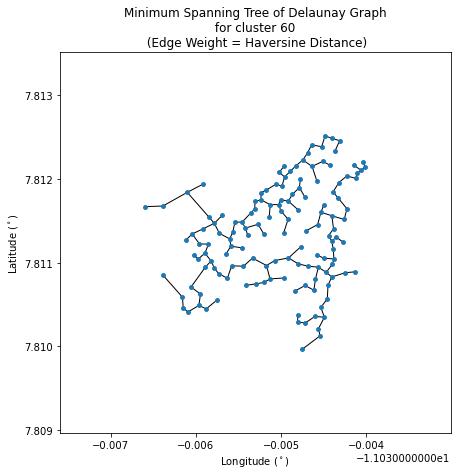

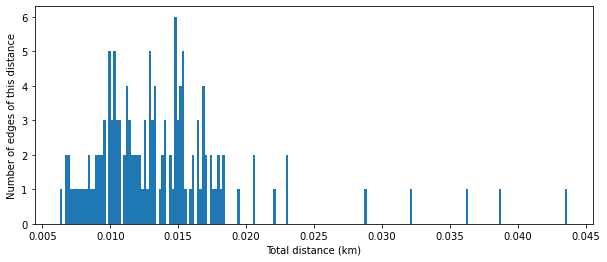

Number of nodes (buildings) in the graph:  96
Number of edges in the minimum spanning tree:  95
Total distance of minimum spanning tree (in km):  1.618249282248702


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


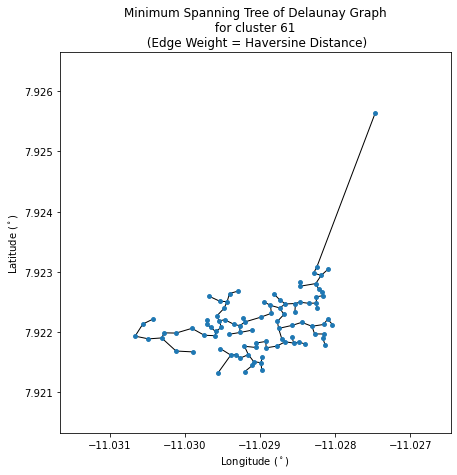

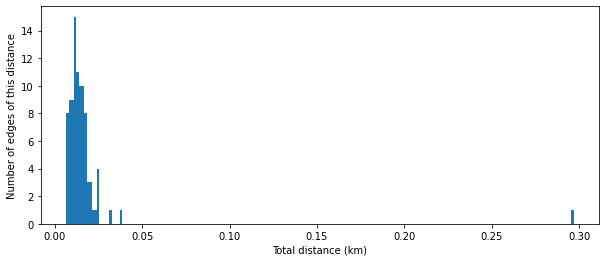

Number of nodes (buildings) in the graph:  58
Number of edges in the minimum spanning tree:  57
Total distance of minimum spanning tree (in km):  1.2597326566579594


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


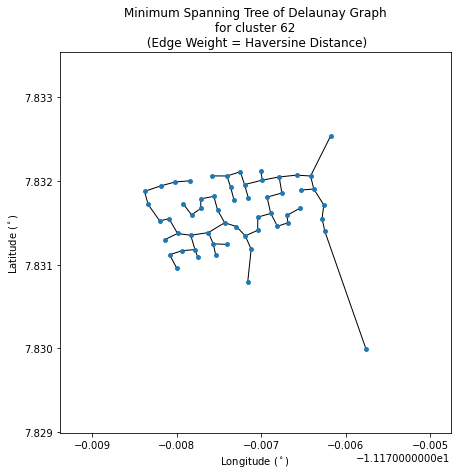

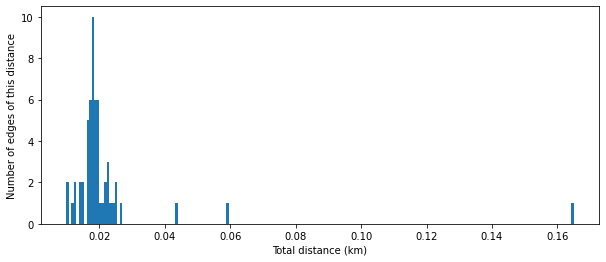

Number of nodes (buildings) in the graph:  71
Number of edges in the minimum spanning tree:  70
Total distance of minimum spanning tree (in km):  1.1084526533678432


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


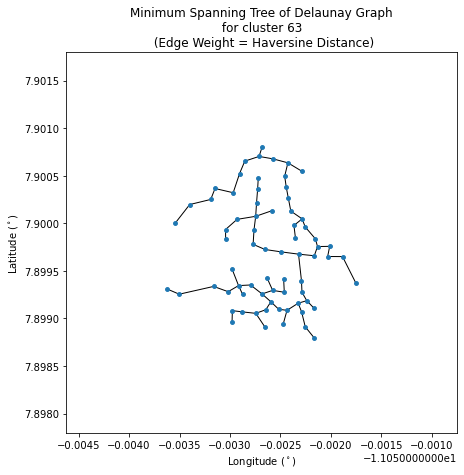

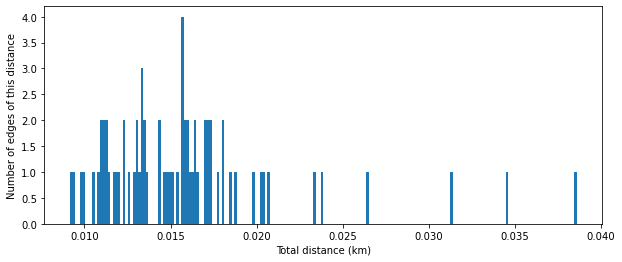

Number of nodes (buildings) in the graph:  58
Number of edges in the minimum spanning tree:  57
Total distance of minimum spanning tree (in km):  0.8530644869085273


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


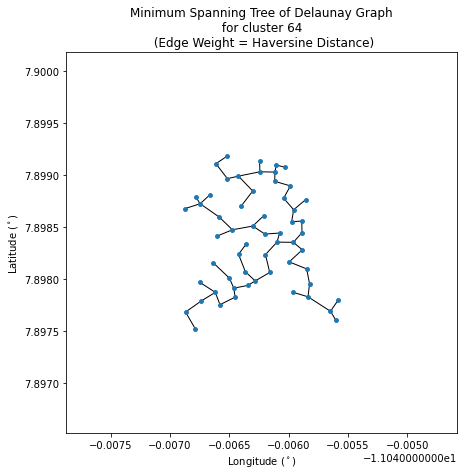

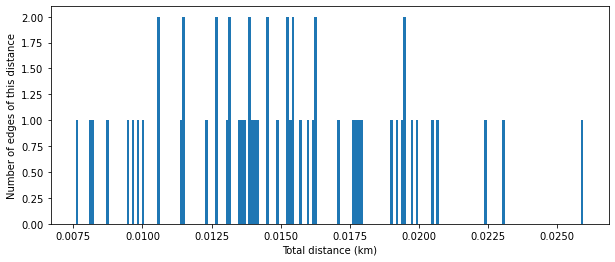

Number of nodes (buildings) in the graph:  59
Number of edges in the minimum spanning tree:  58
Total distance of minimum spanning tree (in km):  0.6999085629307715


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


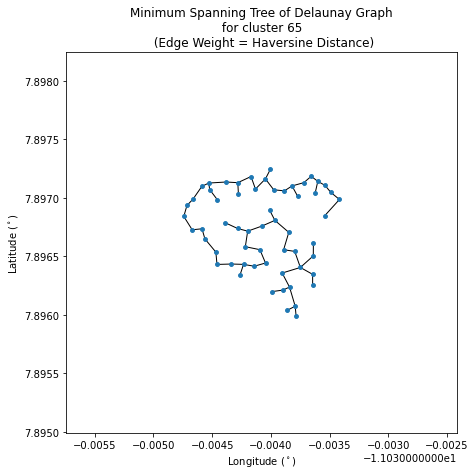

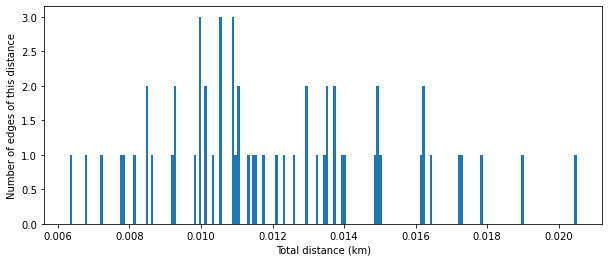

Number of nodes (buildings) in the graph:  203
Number of edges in the minimum spanning tree:  202
Total distance of minimum spanning tree (in km):  3.089117576058215


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


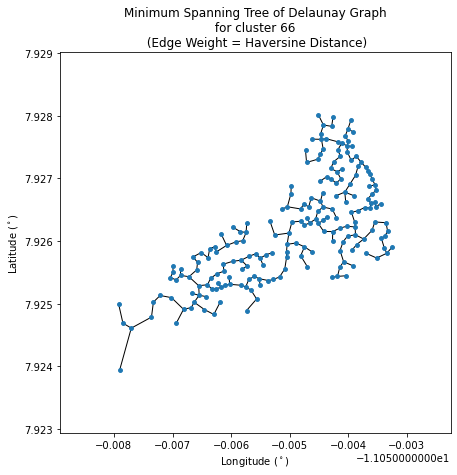

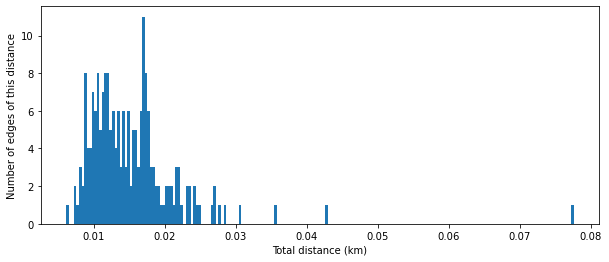

Number of nodes (buildings) in the graph:  113
Number of edges in the minimum spanning tree:  112
Total distance of minimum spanning tree (in km):  2.055694809135849


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


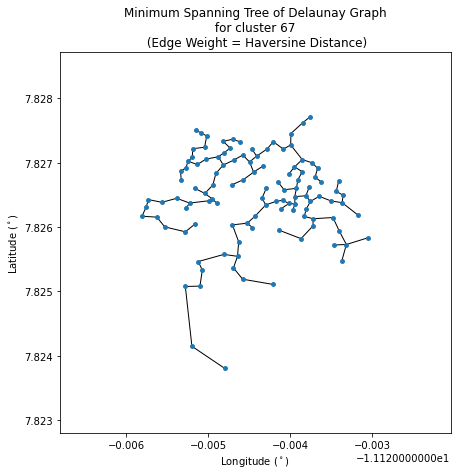

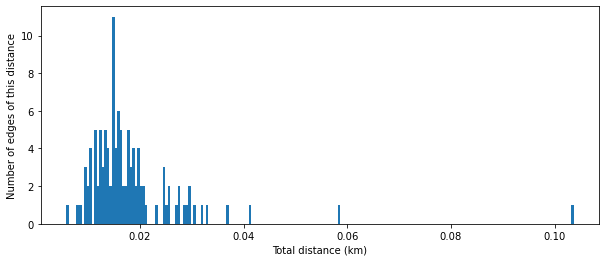

Number of nodes (buildings) in the graph:  57
Number of edges in the minimum spanning tree:  56
Total distance of minimum spanning tree (in km):  0.6889641127031519


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


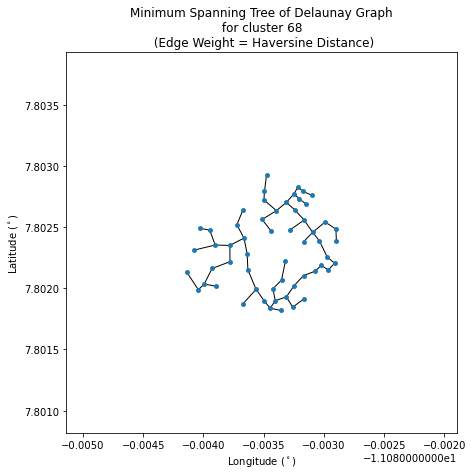

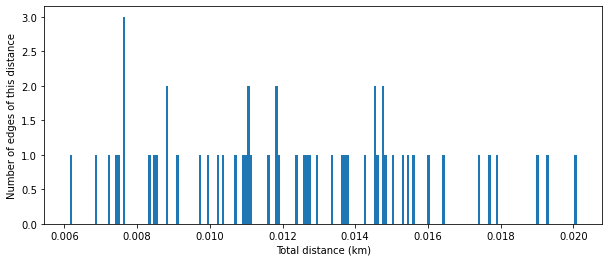

Number of nodes (buildings) in the graph:  93
Number of edges in the minimum spanning tree:  92
Total distance of minimum spanning tree (in km):  1.0845617117544317


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


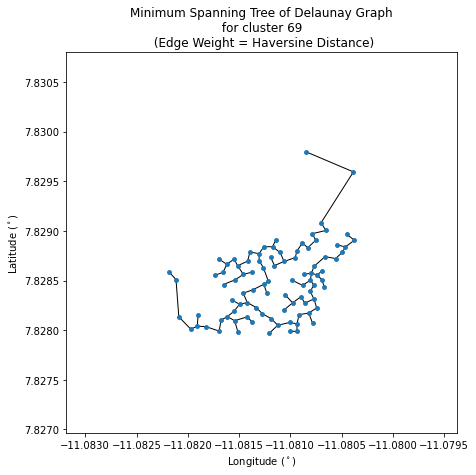

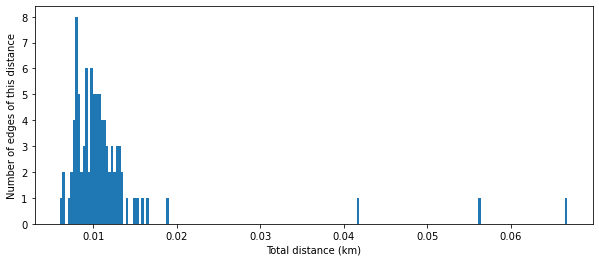

Number of nodes (buildings) in the graph:  62
Number of edges in the minimum spanning tree:  61
Total distance of minimum spanning tree (in km):  0.659373341019156


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


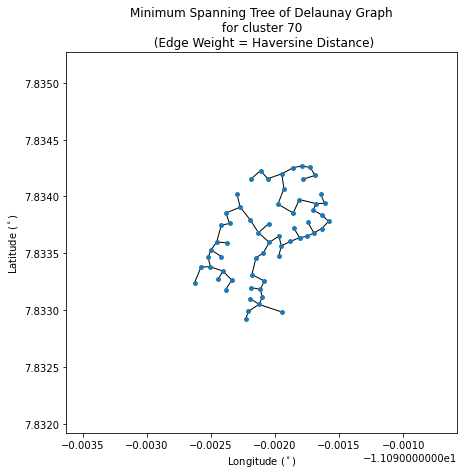

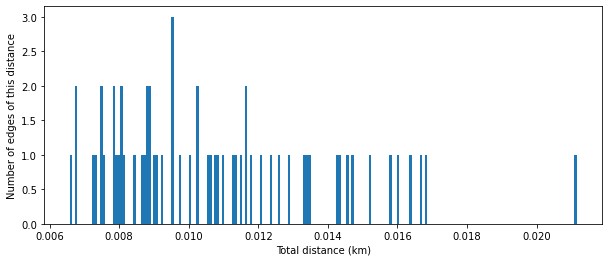

Number of nodes (buildings) in the graph:  110
Number of edges in the minimum spanning tree:  109
Total distance of minimum spanning tree (in km):  2.2143951597787956


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


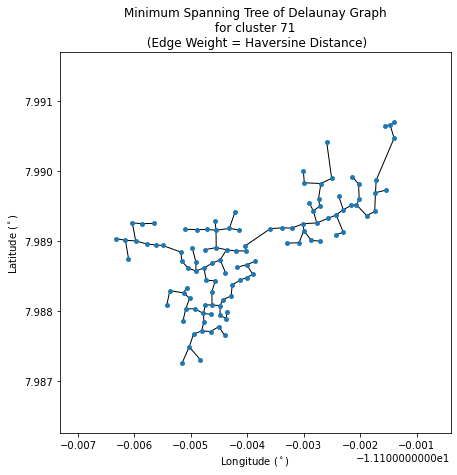

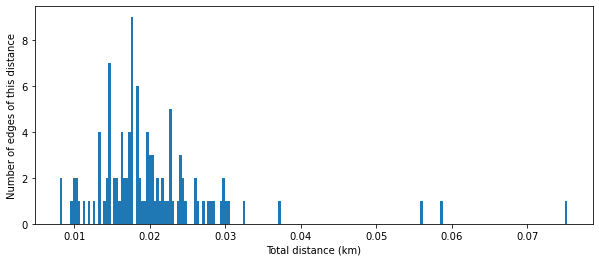

Number of nodes (buildings) in the graph:  194
Number of edges in the minimum spanning tree:  193
Total distance of minimum spanning tree (in km):  3.332536718472927


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


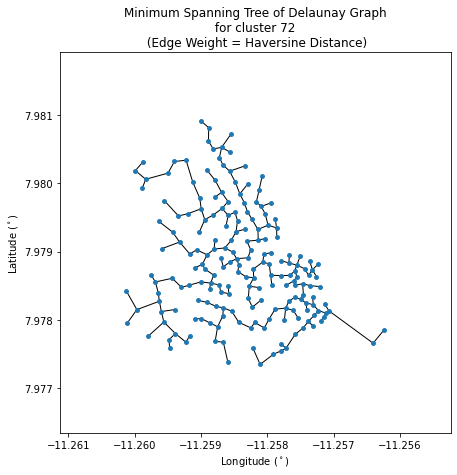

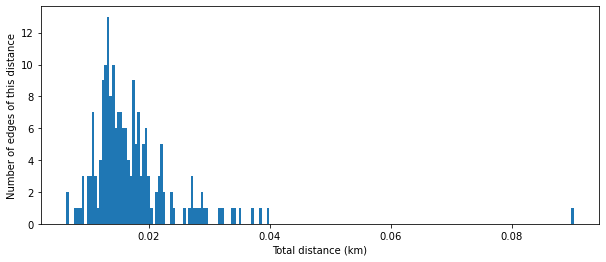

Number of nodes (buildings) in the graph:  68
Number of edges in the minimum spanning tree:  67
Total distance of minimum spanning tree (in km):  1.220756519725547


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


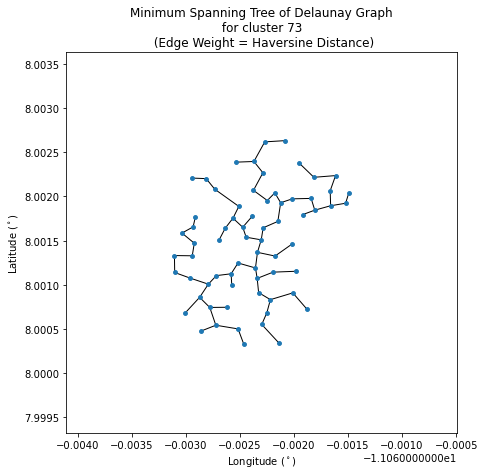

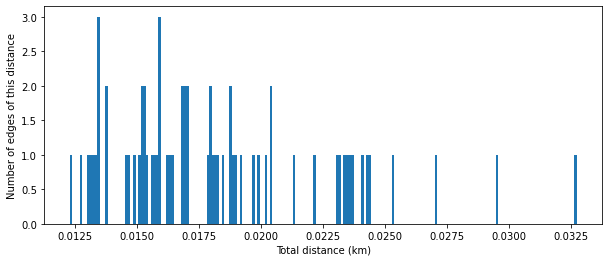

Number of nodes (buildings) in the graph:  67
Number of edges in the minimum spanning tree:  66
Total distance of minimum spanning tree (in km):  0.9120659525738457


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


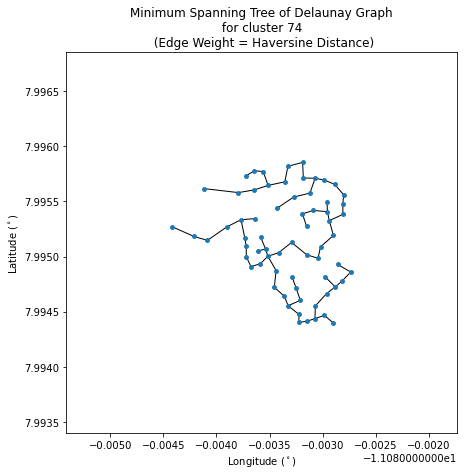

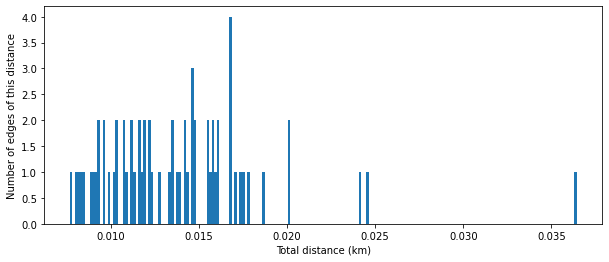

Number of nodes (buildings) in the graph:  59
Number of edges in the minimum spanning tree:  58
Total distance of minimum spanning tree (in km):  1.214466821754747


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


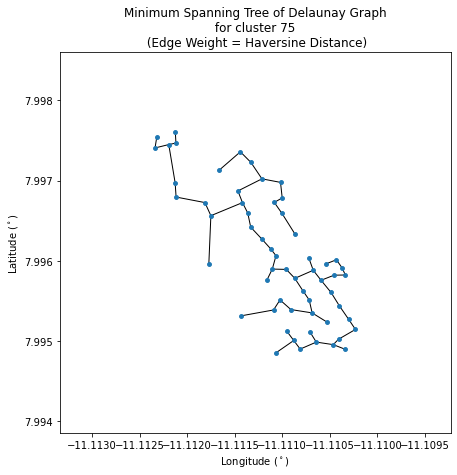

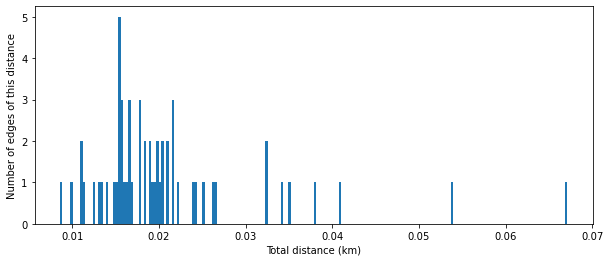

Number of nodes (buildings) in the graph:  97
Number of edges in the minimum spanning tree:  96
Total distance of minimum spanning tree (in km):  2.4739884367537117


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


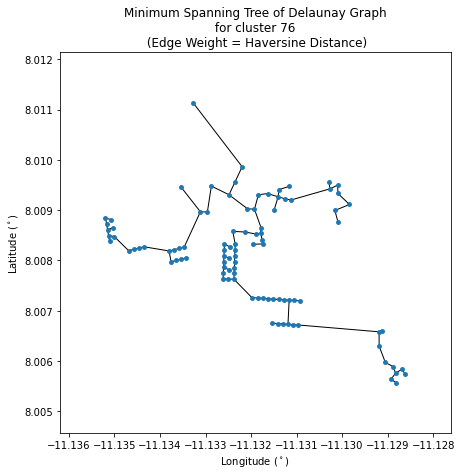

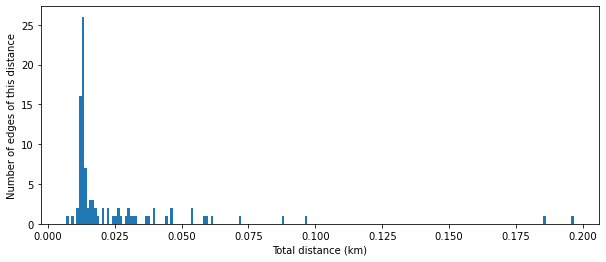

Number of nodes (buildings) in the graph:  55
Number of edges in the minimum spanning tree:  54
Total distance of minimum spanning tree (in km):  1.120978170776562


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


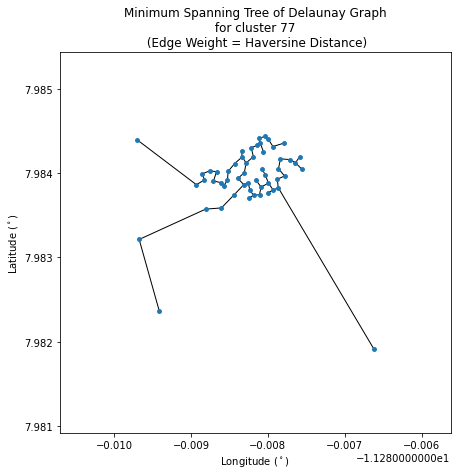

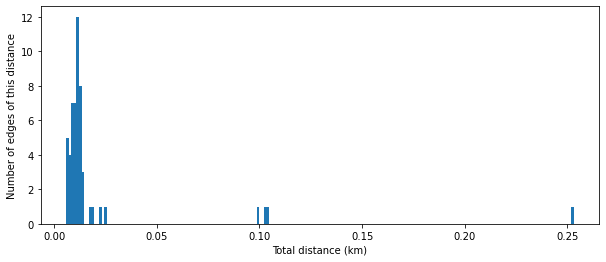

Number of nodes (buildings) in the graph:  59
Number of edges in the minimum spanning tree:  58
Total distance of minimum spanning tree (in km):  0.856785145623954


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


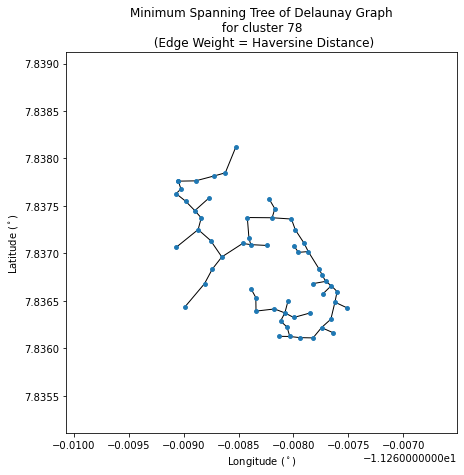

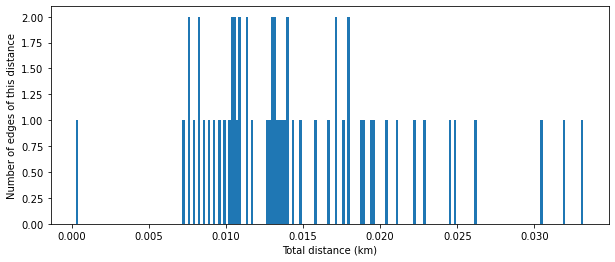

Number of nodes (buildings) in the graph:  55
Number of edges in the minimum spanning tree:  54
Total distance of minimum spanning tree (in km):  0.6502436685745611


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


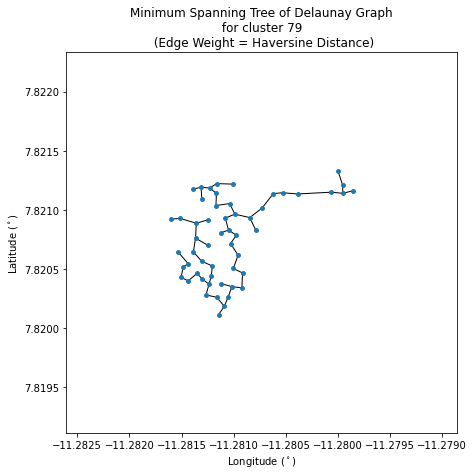

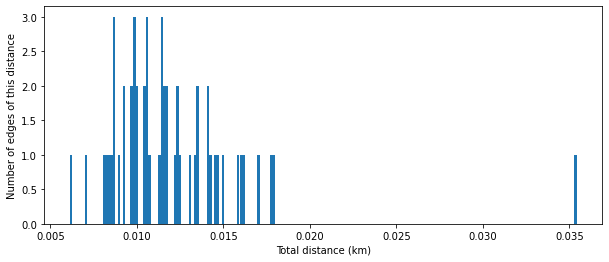

Number of nodes (buildings) in the graph:  93
Number of edges in the minimum spanning tree:  92
Total distance of minimum spanning tree (in km):  1.5133346180096015


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


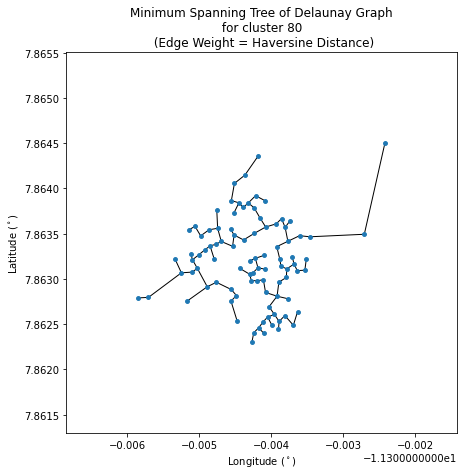

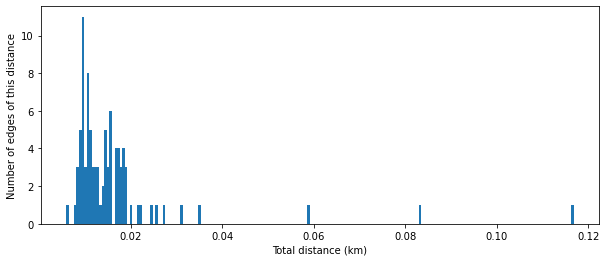

Number of nodes (buildings) in the graph:  77
Number of edges in the minimum spanning tree:  76
Total distance of minimum spanning tree (in km):  1.843236813780333


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


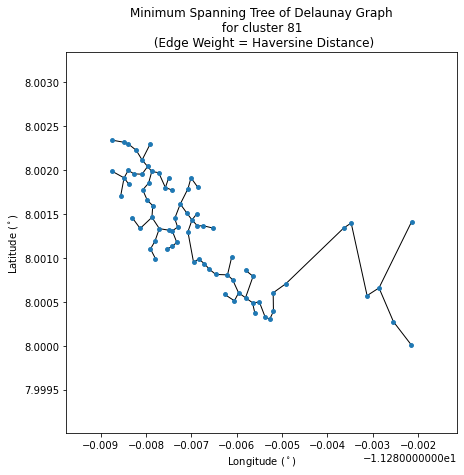

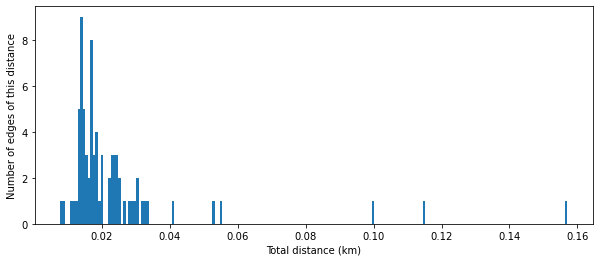

Number of nodes (buildings) in the graph:  77
Number of edges in the minimum spanning tree:  76
Total distance of minimum spanning tree (in km):  1.3109490957040941


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


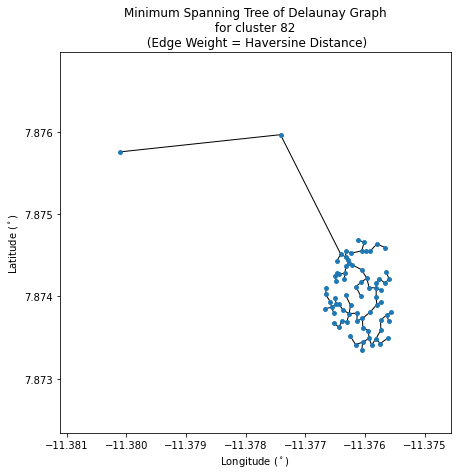

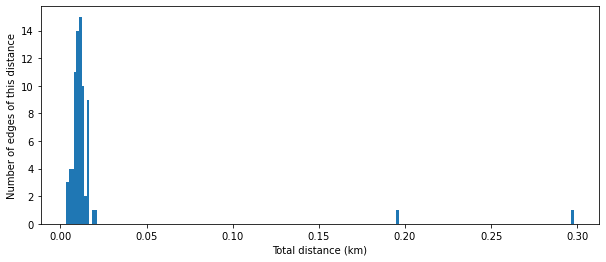

Number of nodes (buildings) in the graph:  73
Number of edges in the minimum spanning tree:  72
Total distance of minimum spanning tree (in km):  1.226420916041697


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


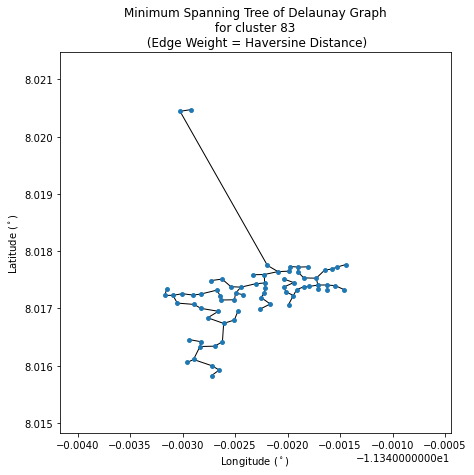

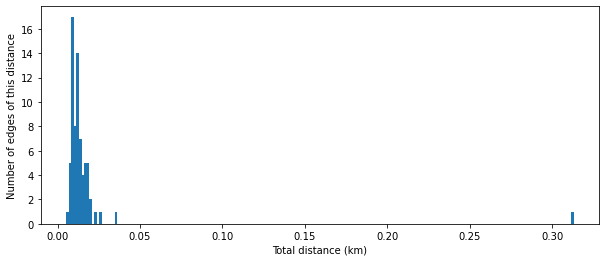

Number of nodes (buildings) in the graph:  89
Number of edges in the minimum spanning tree:  88
Total distance of minimum spanning tree (in km):  1.253727338831901


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


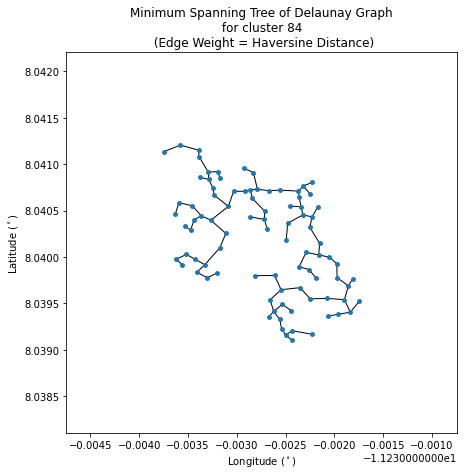

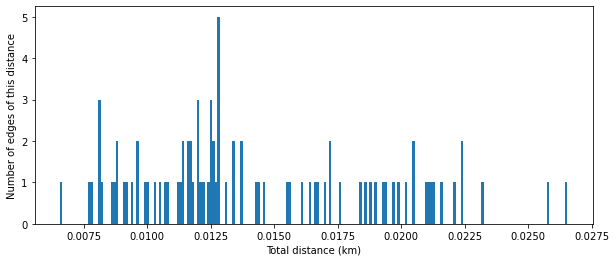

Number of nodes (buildings) in the graph:  63
Number of edges in the minimum spanning tree:  62
Total distance of minimum spanning tree (in km):  0.9589986204173179


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


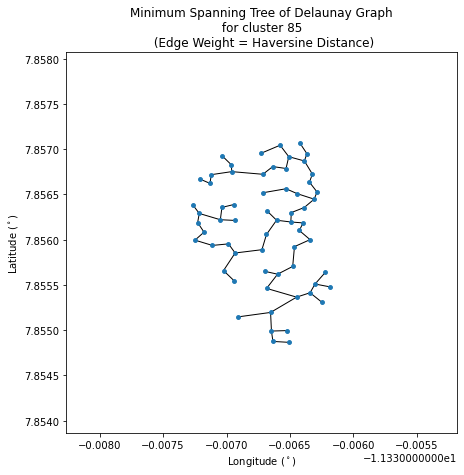

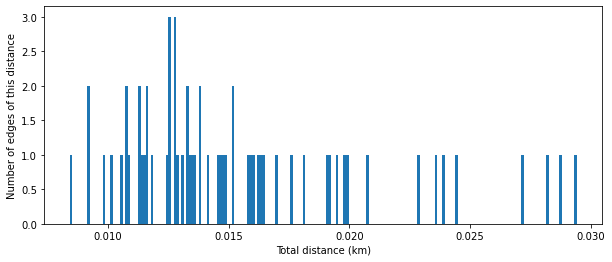

Number of nodes (buildings) in the graph:  160
Number of edges in the minimum spanning tree:  159
Total distance of minimum spanning tree (in km):  2.7872332937231783


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


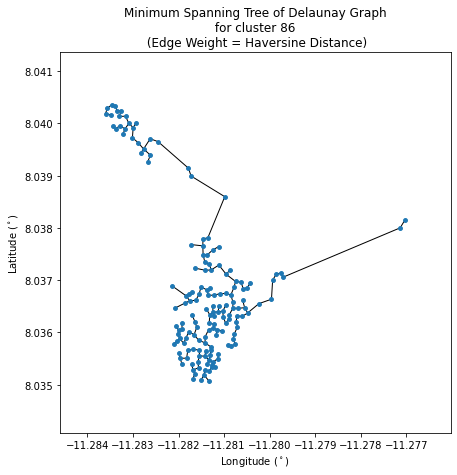

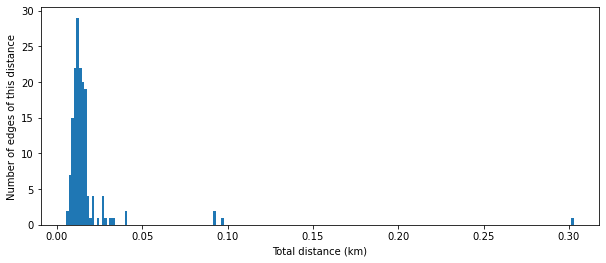

Number of nodes (buildings) in the graph:  110
Number of edges in the minimum spanning tree:  109
Total distance of minimum spanning tree (in km):  2.003985847936874


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


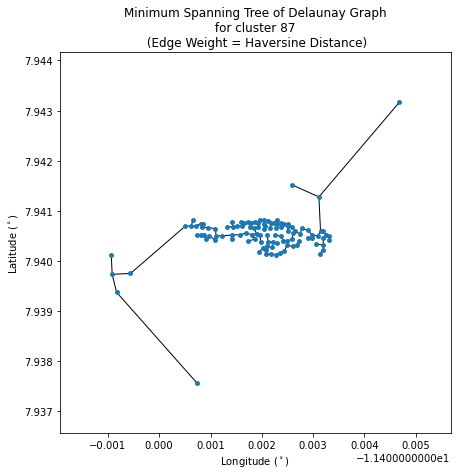

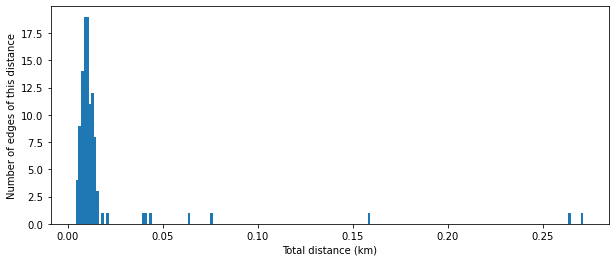

Number of nodes (buildings) in the graph:  71
Number of edges in the minimum spanning tree:  70
Total distance of minimum spanning tree (in km):  1.4363206138642801


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


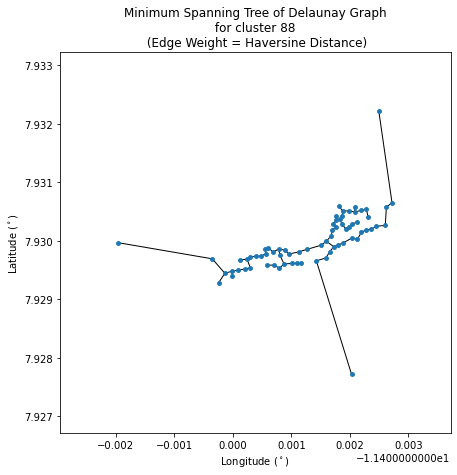

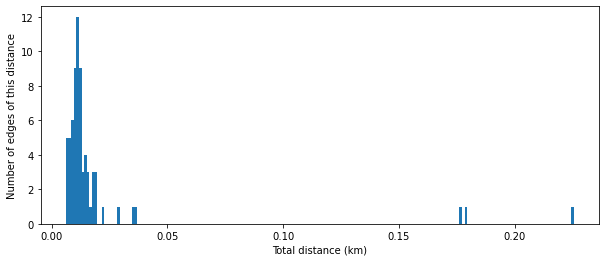

Number of nodes (buildings) in the graph:  52
Number of edges in the minimum spanning tree:  51
Total distance of minimum spanning tree (in km):  0.5903299470987463


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


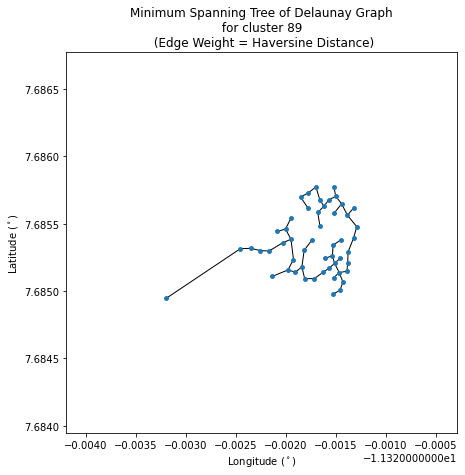

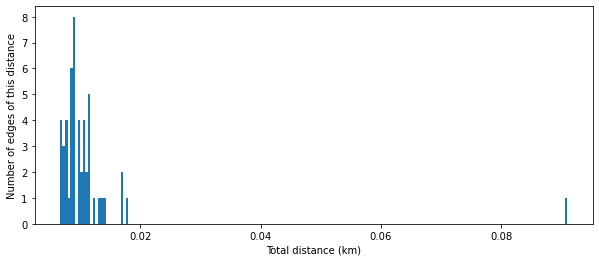

Number of nodes (buildings) in the graph:  58
Number of edges in the minimum spanning tree:  57
Total distance of minimum spanning tree (in km):  1.3259563195433701


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


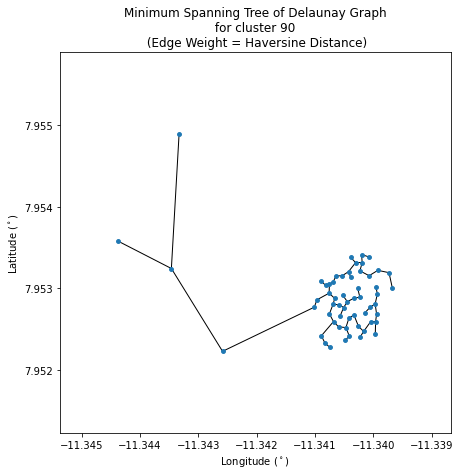

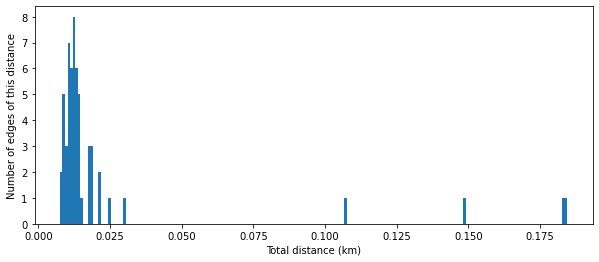

Number of nodes (buildings) in the graph:  52
Number of edges in the minimum spanning tree:  51
Total distance of minimum spanning tree (in km):  1.1064355398852213


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


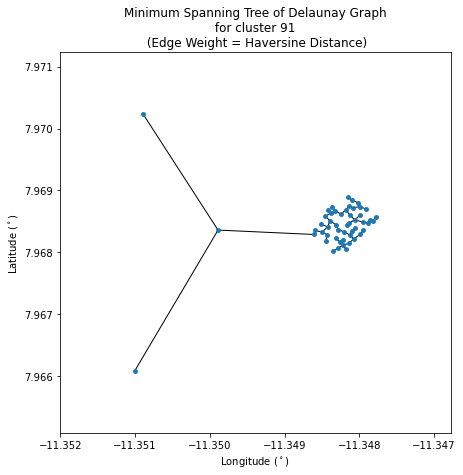

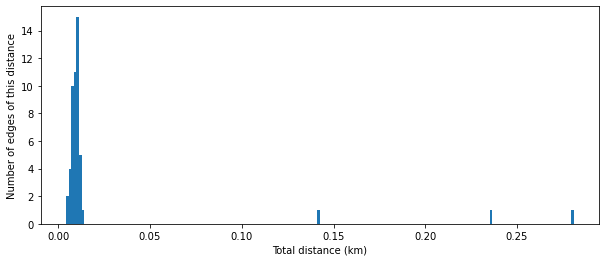

Number of nodes (buildings) in the graph:  193
Number of edges in the minimum spanning tree:  192
Total distance of minimum spanning tree (in km):  3.62855552278979


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


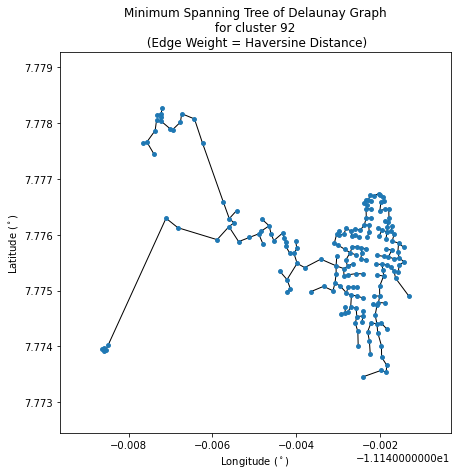

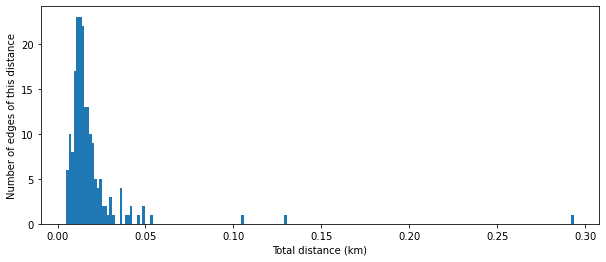

Number of nodes (buildings) in the graph:  97
Number of edges in the minimum spanning tree:  96
Total distance of minimum spanning tree (in km):  1.369901343140804


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


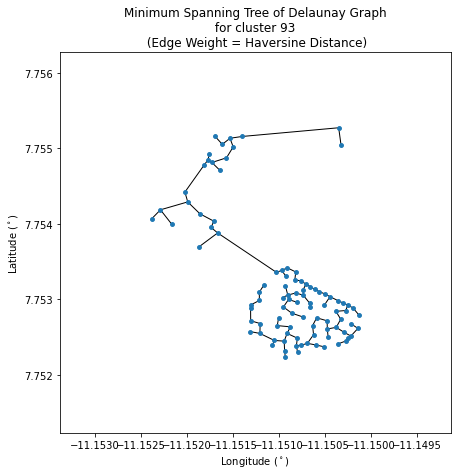

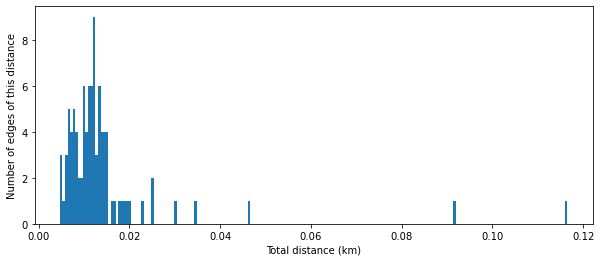

Number of nodes (buildings) in the graph:  132
Number of edges in the minimum spanning tree:  131
Total distance of minimum spanning tree (in km):  1.5619757635237215


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


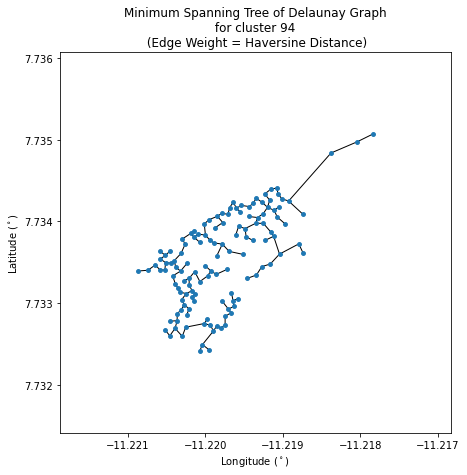

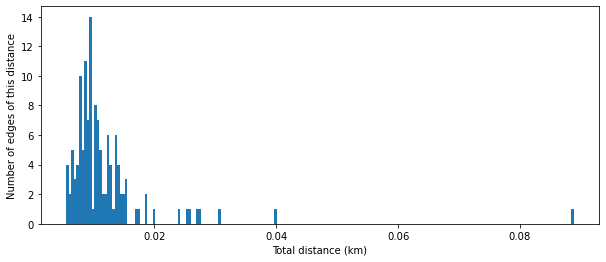

Number of nodes (buildings) in the graph:  194
Number of edges in the minimum spanning tree:  193
Total distance of minimum spanning tree (in km):  2.112728212910192


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


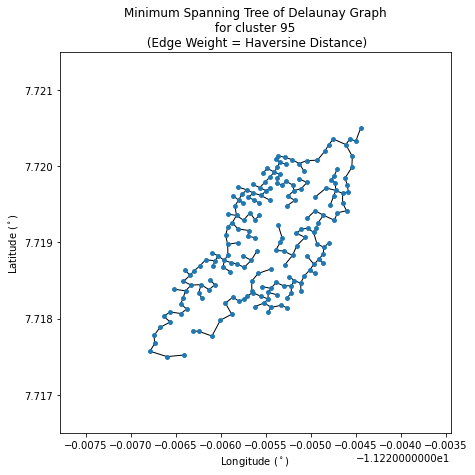

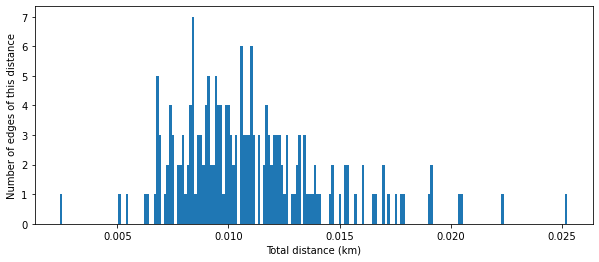

Number of nodes (buildings) in the graph:  82
Number of edges in the minimum spanning tree:  81
Total distance of minimum spanning tree (in km):  0.8970846134145118


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


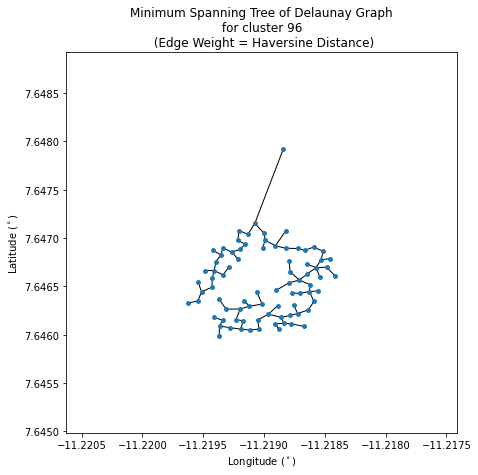

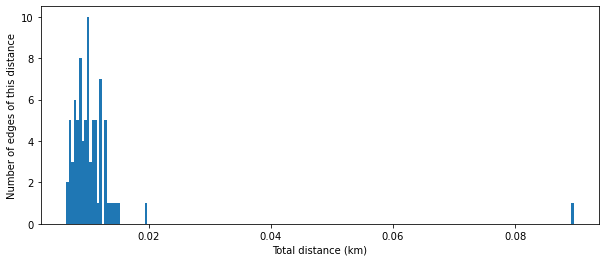

Number of nodes (buildings) in the graph:  411
Number of edges in the minimum spanning tree:  410
Total distance of minimum spanning tree (in km):  5.836869744682047


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


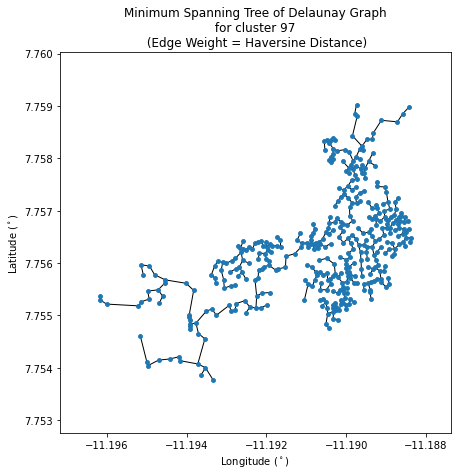

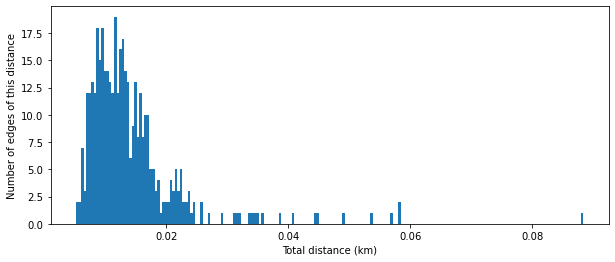

Number of nodes (buildings) in the graph:  132
Number of edges in the minimum spanning tree:  131
Total distance of minimum spanning tree (in km):  2.160565585503779


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


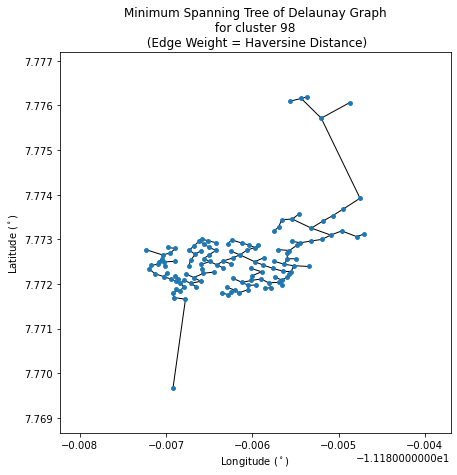

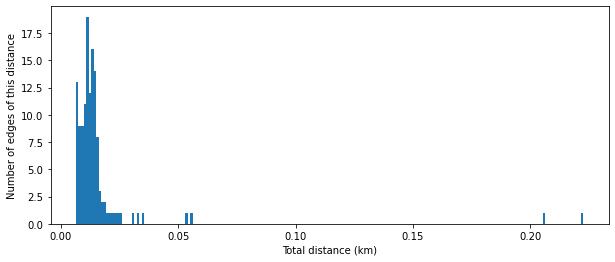

Number of nodes (buildings) in the graph:  67
Number of edges in the minimum spanning tree:  66
Total distance of minimum spanning tree (in km):  1.028379372899939


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


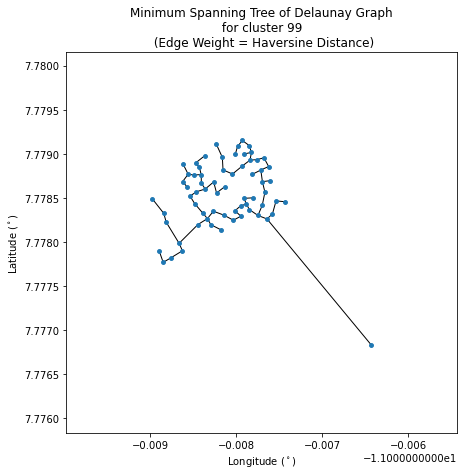

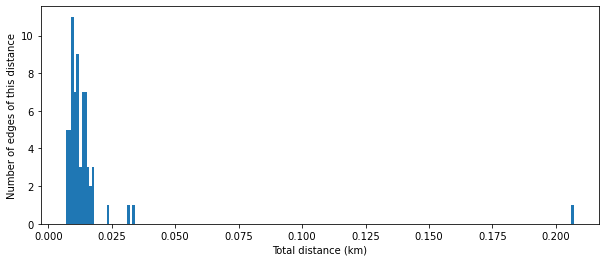

Number of nodes (buildings) in the graph:  81
Number of edges in the minimum spanning tree:  80
Total distance of minimum spanning tree (in km):  1.2460104275272172


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


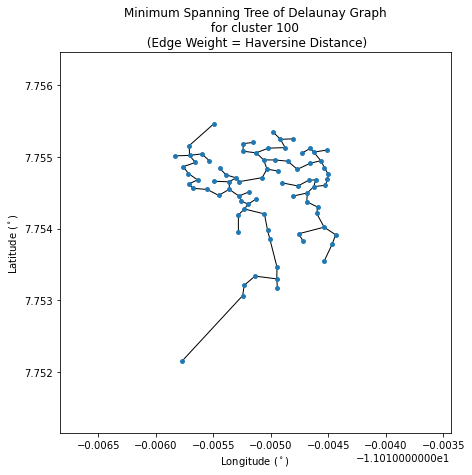

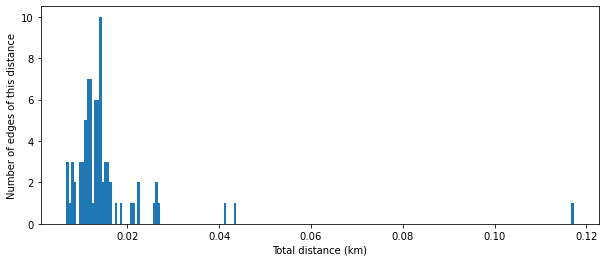

Number of nodes (buildings) in the graph:  425
Number of edges in the minimum spanning tree:  424
Total distance of minimum spanning tree (in km):  4.336176439468714


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


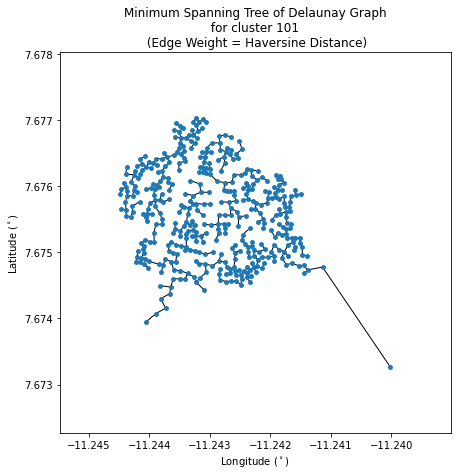

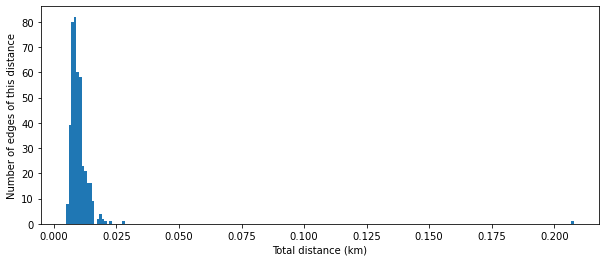

Number of nodes (buildings) in the graph:  87
Number of edges in the minimum spanning tree:  86
Total distance of minimum spanning tree (in km):  0.8907924532668352


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


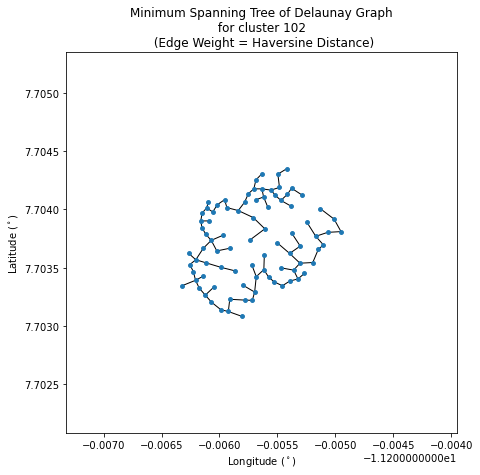

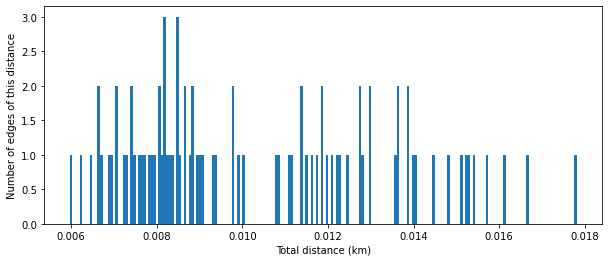

Number of nodes (buildings) in the graph:  122
Number of edges in the minimum spanning tree:  121
Total distance of minimum spanning tree (in km):  1.2779280579685843


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


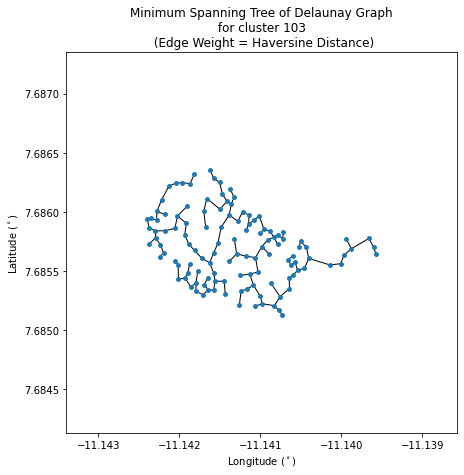

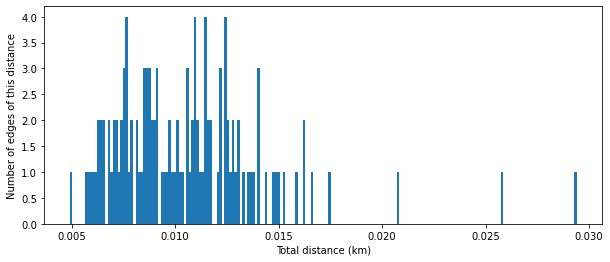

Number of nodes (buildings) in the graph:  116
Number of edges in the minimum spanning tree:  115
Total distance of minimum spanning tree (in km):  1.5221874302908671


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


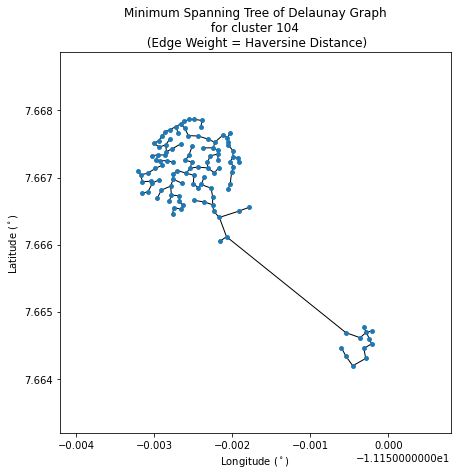

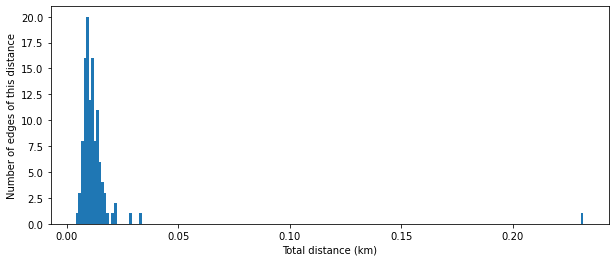

Number of nodes (buildings) in the graph:  137
Number of edges in the minimum spanning tree:  136
Total distance of minimum spanning tree (in km):  1.5051996526187363


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


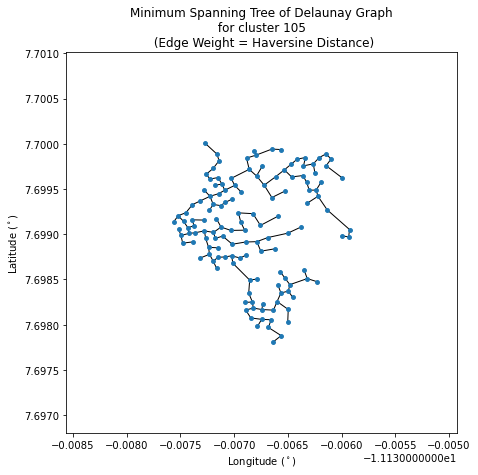

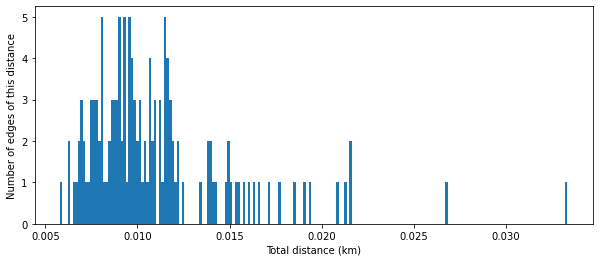

Number of nodes (buildings) in the graph:  58
Number of edges in the minimum spanning tree:  57
Total distance of minimum spanning tree (in km):  0.722001151097233


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


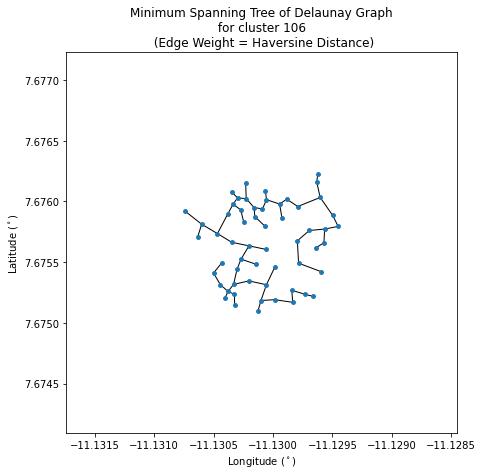

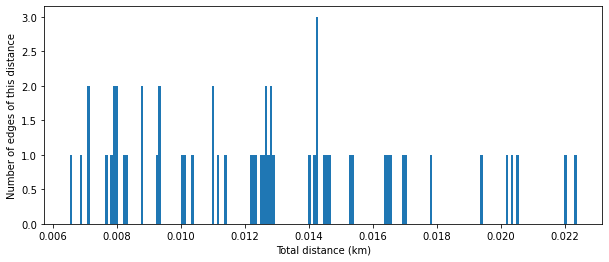

Number of nodes (buildings) in the graph:  58
Number of edges in the minimum spanning tree:  57
Total distance of minimum spanning tree (in km):  0.9076920953105664


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


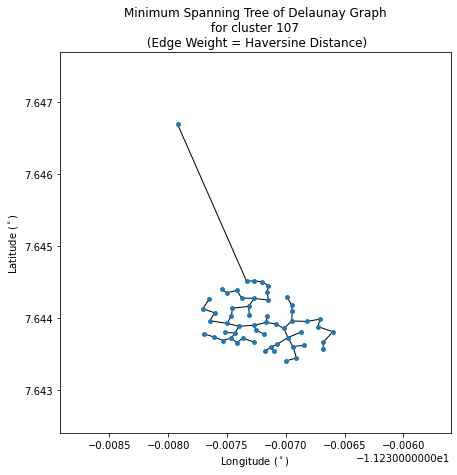

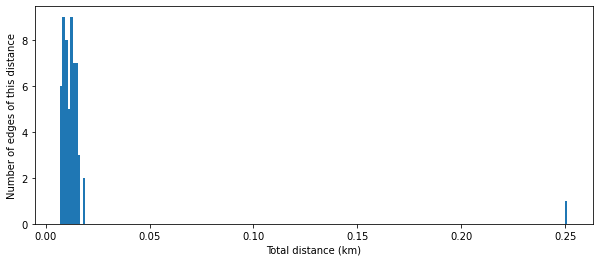

Number of nodes (buildings) in the graph:  98
Number of edges in the minimum spanning tree:  97
Total distance of minimum spanning tree (in km):  1.4285782051854796


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


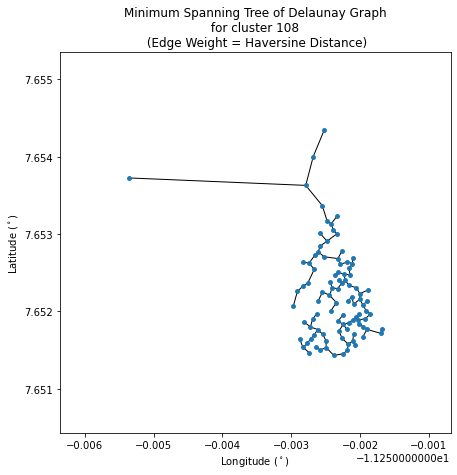

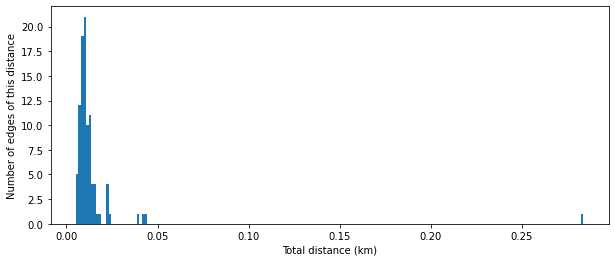

Number of nodes (buildings) in the graph:  245
Number of edges in the minimum spanning tree:  244
Total distance of minimum spanning tree (in km):  4.086953246890626


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


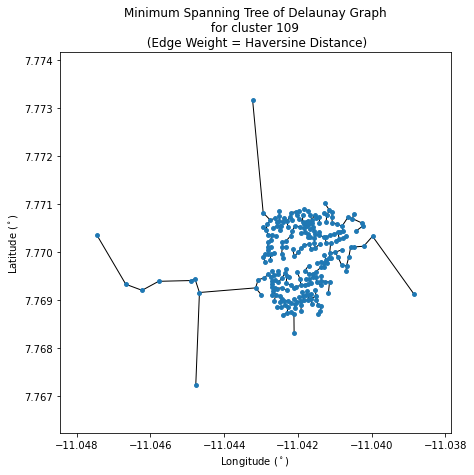

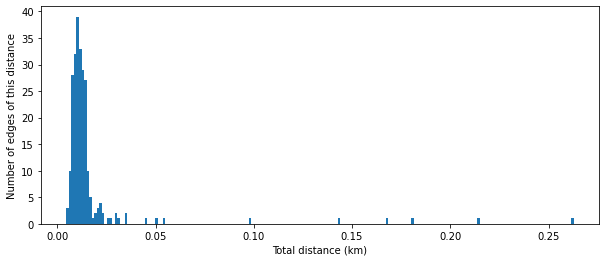

Number of nodes (buildings) in the graph:  332
Number of edges in the minimum spanning tree:  331
Total distance of minimum spanning tree (in km):  6.599837012719493


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


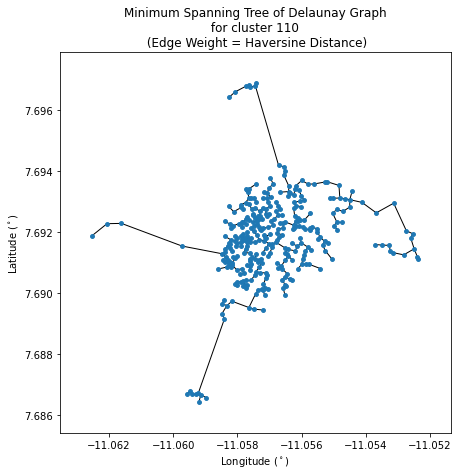

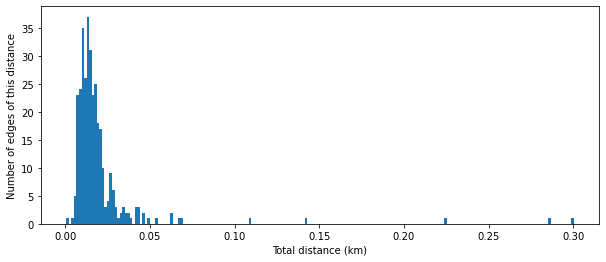

Number of nodes (buildings) in the graph:  87
Number of edges in the minimum spanning tree:  86
Total distance of minimum spanning tree (in km):  0.964389733894305


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


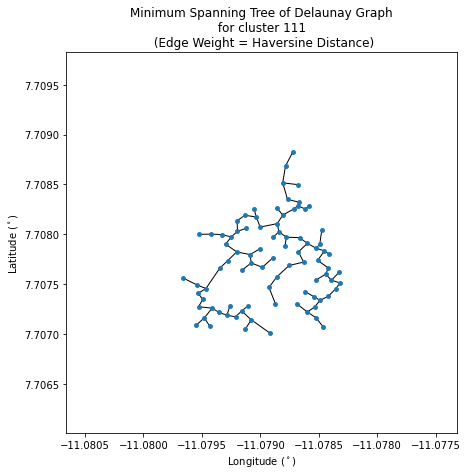

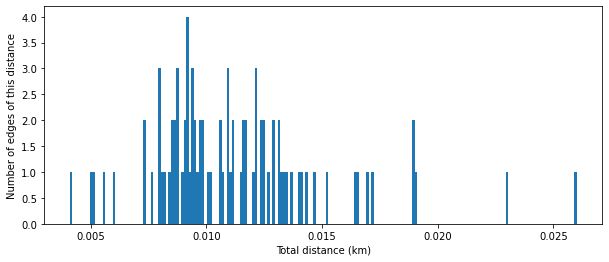

Number of nodes (buildings) in the graph:  92
Number of edges in the minimum spanning tree:  91
Total distance of minimum spanning tree (in km):  1.3292638911559325


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


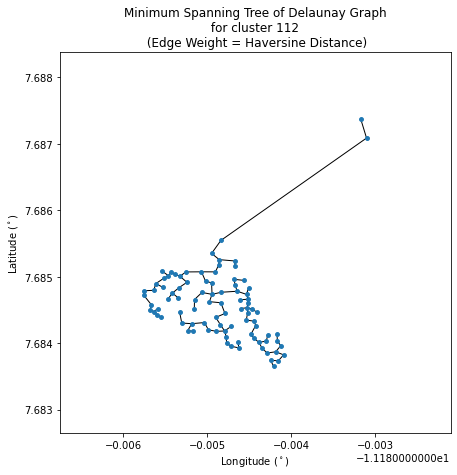

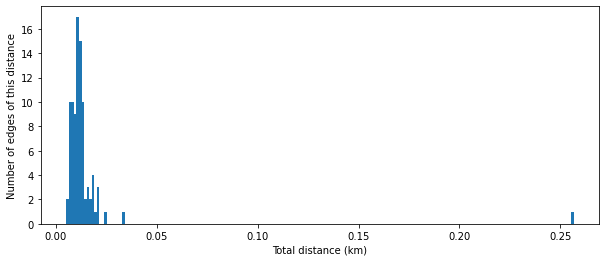

Number of nodes (buildings) in the graph:  165
Number of edges in the minimum spanning tree:  164
Total distance of minimum spanning tree (in km):  2.1498249947627195


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


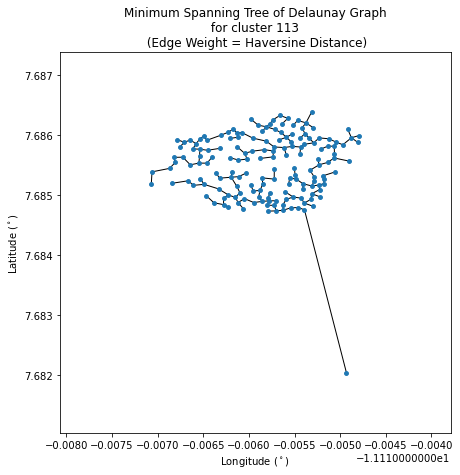

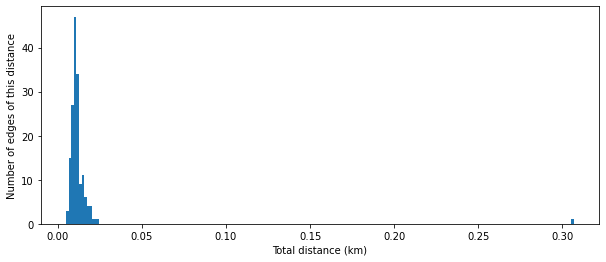

Number of nodes (buildings) in the graph:  99
Number of edges in the minimum spanning tree:  98
Total distance of minimum spanning tree (in km):  1.1520355480189743


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


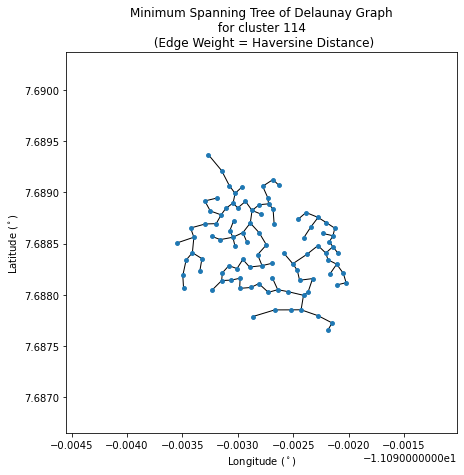

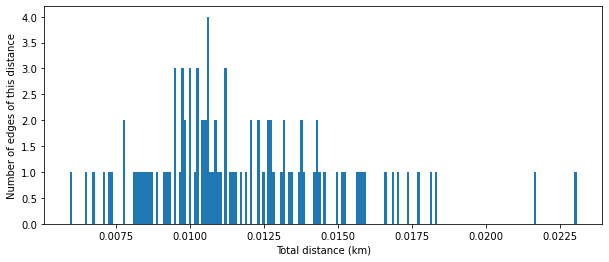

Number of nodes (buildings) in the graph:  77
Number of edges in the minimum spanning tree:  76
Total distance of minimum spanning tree (in km):  1.1997416480684793


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


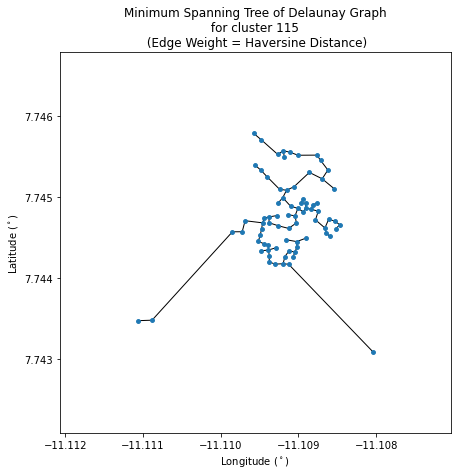

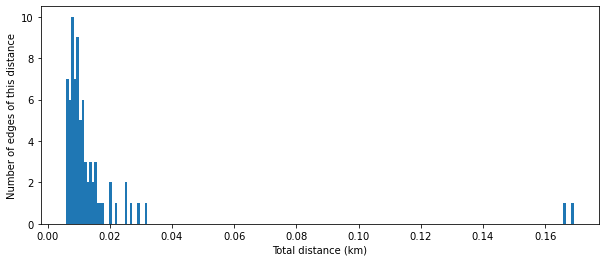

Number of nodes (buildings) in the graph:  69
Number of edges in the minimum spanning tree:  68
Total distance of minimum spanning tree (in km):  0.955966841645324


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


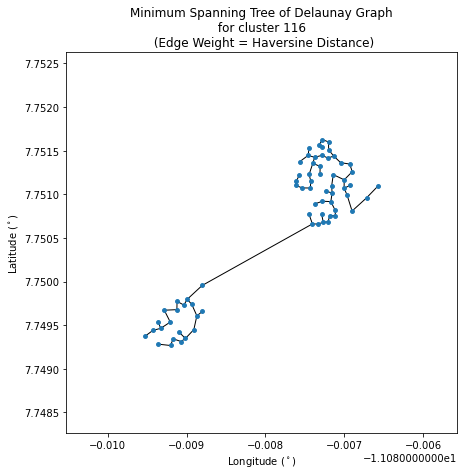

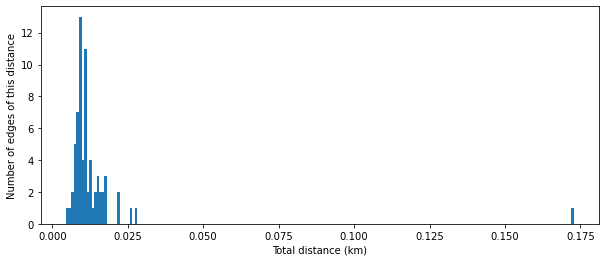

Number of nodes (buildings) in the graph:  78
Number of edges in the minimum spanning tree:  77
Total distance of minimum spanning tree (in km):  0.9205941253399018


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


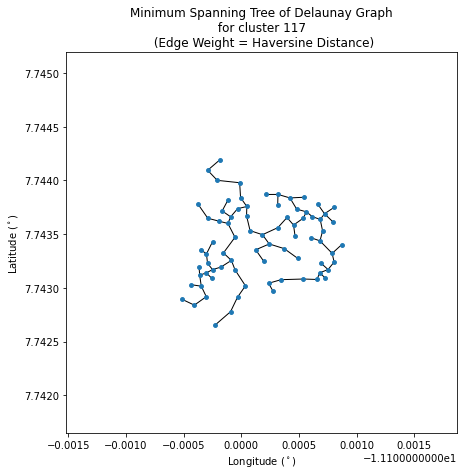

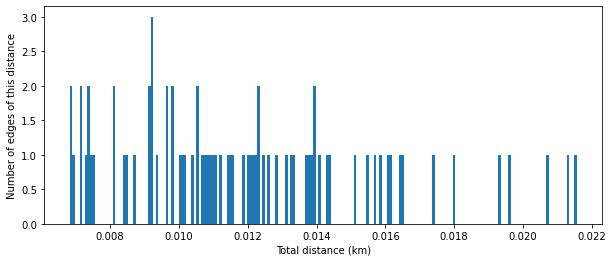

Number of nodes (buildings) in the graph:  94
Number of edges in the minimum spanning tree:  93
Total distance of minimum spanning tree (in km):  1.1782837040459744


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


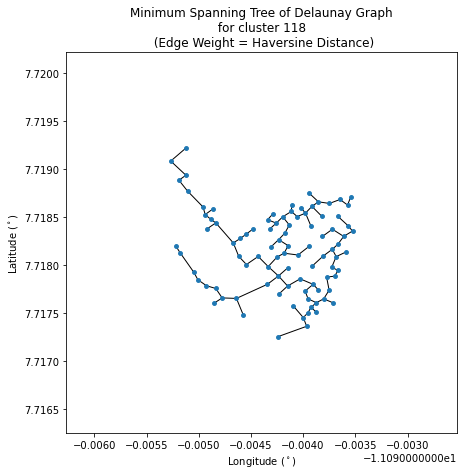

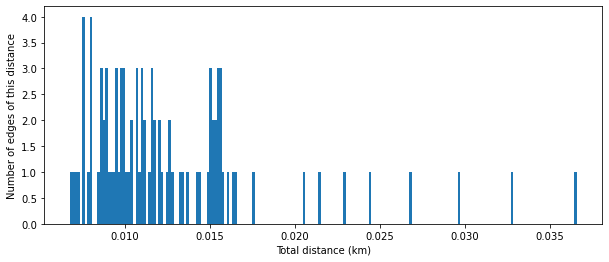

Number of nodes (buildings) in the graph:  71
Number of edges in the minimum spanning tree:  70
Total distance of minimum spanning tree (in km):  0.804469610548704


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


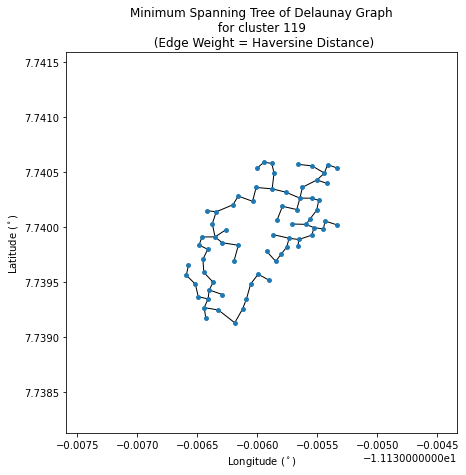

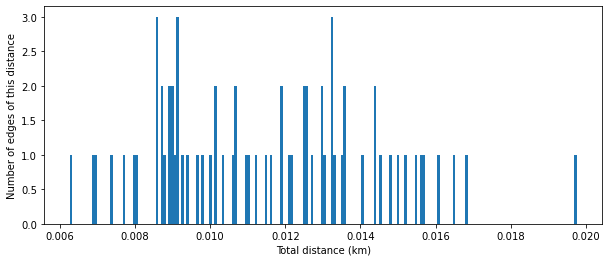

Number of nodes (buildings) in the graph:  94
Number of edges in the minimum spanning tree:  93
Total distance of minimum spanning tree (in km):  1.1769883617405559


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


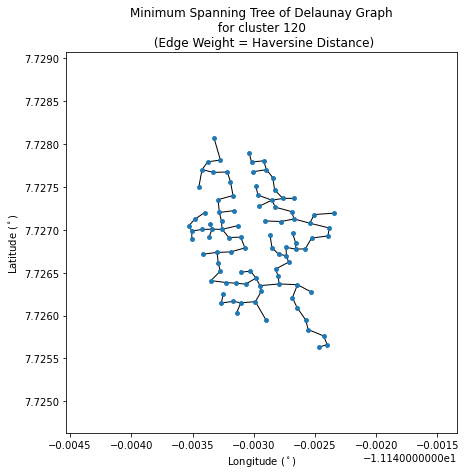

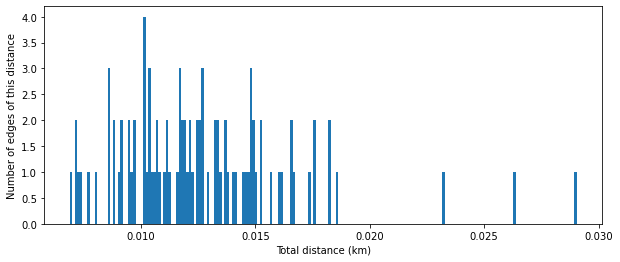

Number of nodes (buildings) in the graph:  50
Number of edges in the minimum spanning tree:  49
Total distance of minimum spanning tree (in km):  0.5567526011228169


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


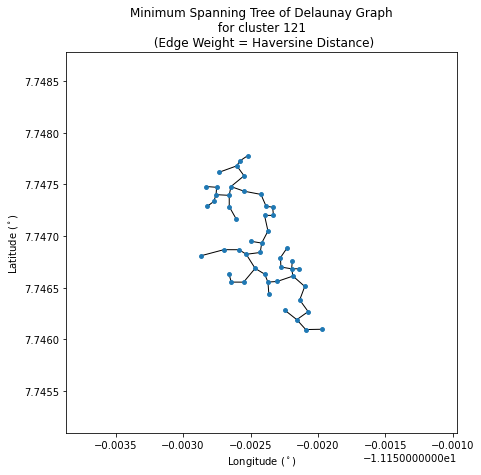

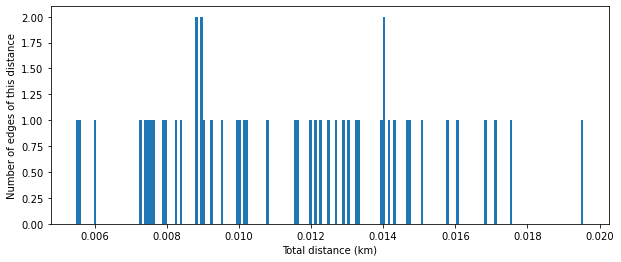

Number of nodes (buildings) in the graph:  51
Number of edges in the minimum spanning tree:  50
Total distance of minimum spanning tree (in km):  0.9823108007945721


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


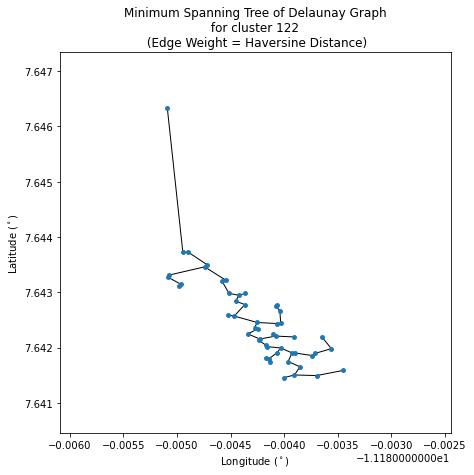

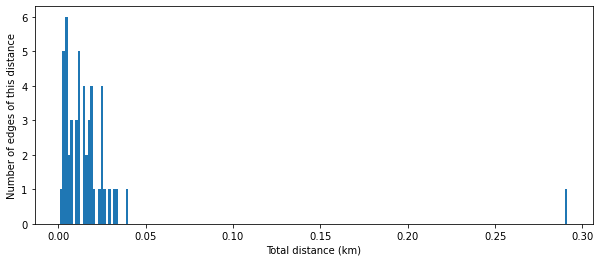

Number of nodes (buildings) in the graph:  132
Number of edges in the minimum spanning tree:  131
Total distance of minimum spanning tree (in km):  1.3704117764318549


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


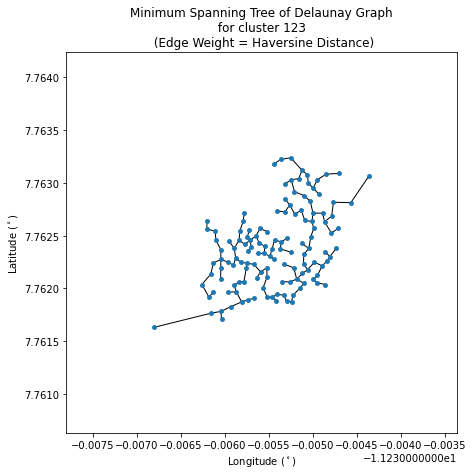

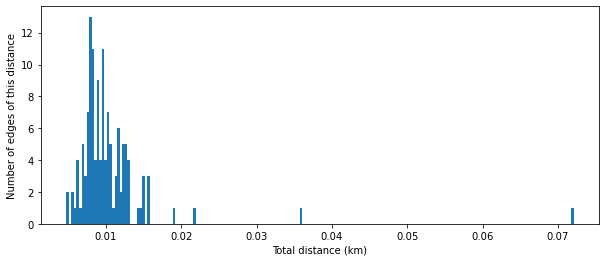

Number of nodes (buildings) in the graph:  188
Number of edges in the minimum spanning tree:  187
Total distance of minimum spanning tree (in km):  2.604750392461247


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


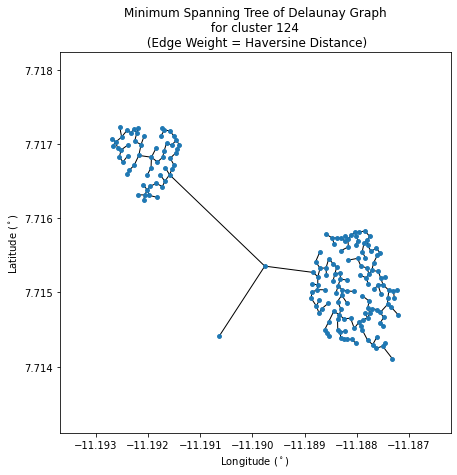

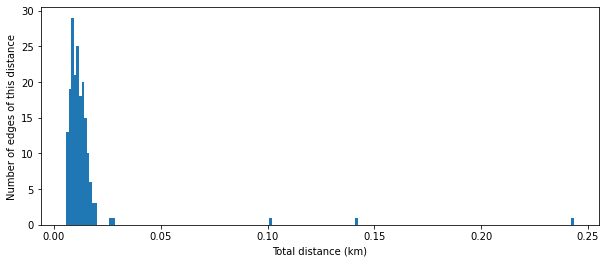

Number of nodes (buildings) in the graph:  63
Number of edges in the minimum spanning tree:  62
Total distance of minimum spanning tree (in km):  1.0033018710706845


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


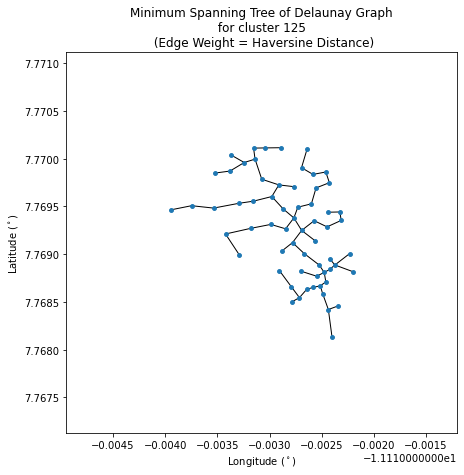

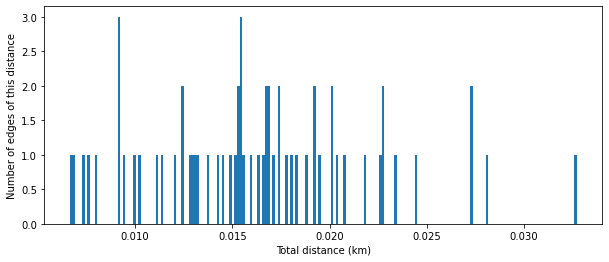

Number of nodes (buildings) in the graph:  54
Number of edges in the minimum spanning tree:  53
Total distance of minimum spanning tree (in km):  0.7440740706014471


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


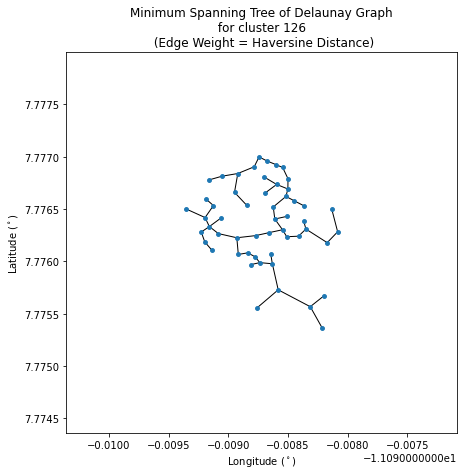

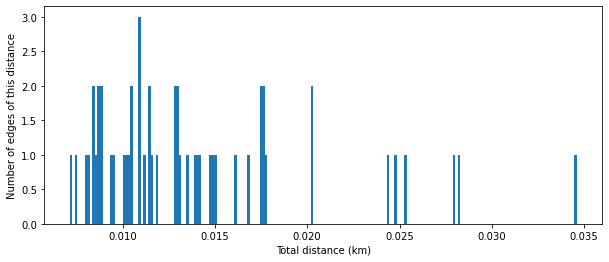

Number of nodes (buildings) in the graph:  99
Number of edges in the minimum spanning tree:  98
Total distance of minimum spanning tree (in km):  1.4740864558219828


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


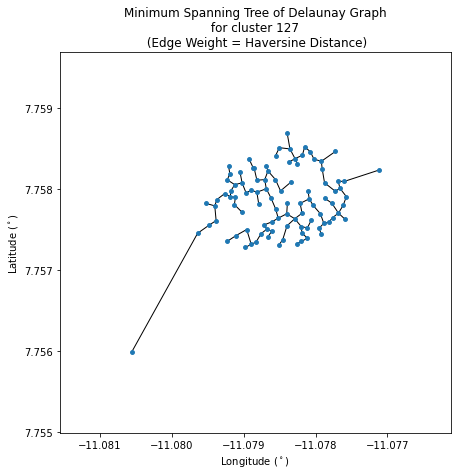

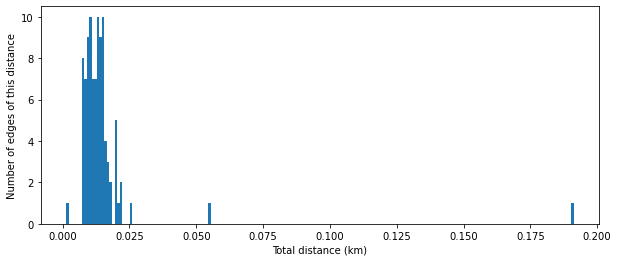

Number of nodes (buildings) in the graph:  72
Number of edges in the minimum spanning tree:  71
Total distance of minimum spanning tree (in km):  1.309525462277974


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


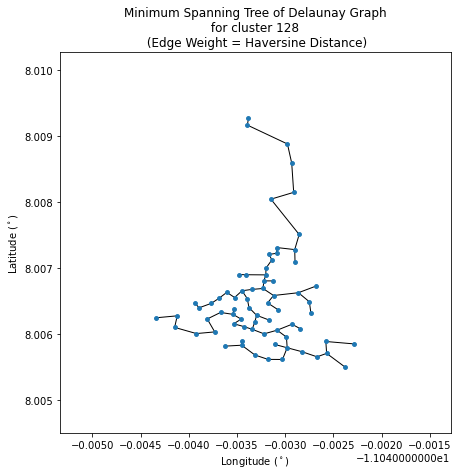

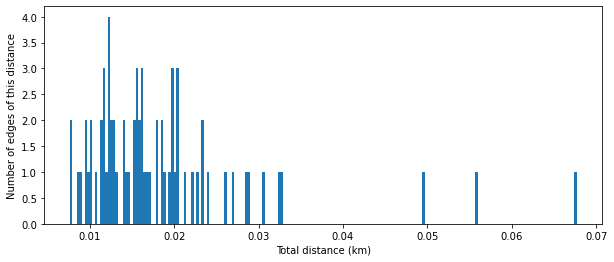

Number of nodes (buildings) in the graph:  377
Number of edges in the minimum spanning tree:  376
Total distance of minimum spanning tree (in km):  7.997128536146408


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


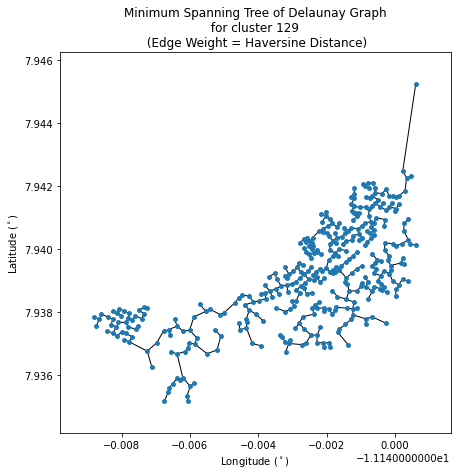

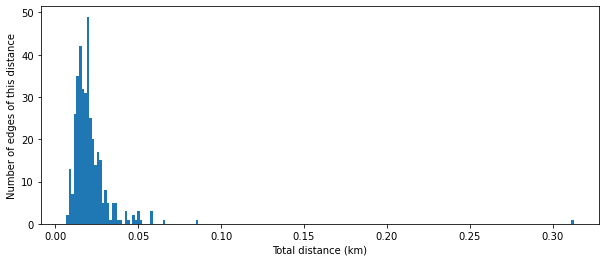

Number of nodes (buildings) in the graph:  87
Number of edges in the minimum spanning tree:  86
Total distance of minimum spanning tree (in km):  1.1127397690300223


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


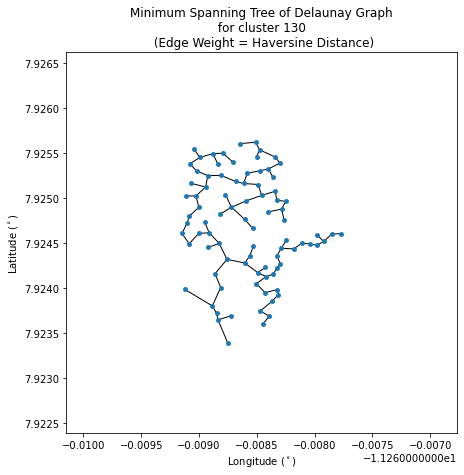

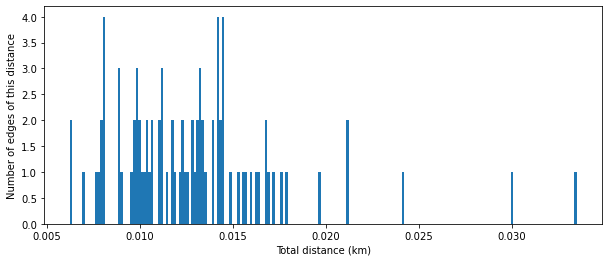

Number of nodes (buildings) in the graph:  246
Number of edges in the minimum spanning tree:  245
Total distance of minimum spanning tree (in km):  4.6269026391908685


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


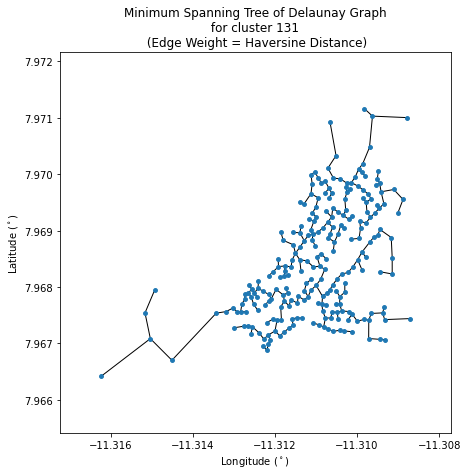

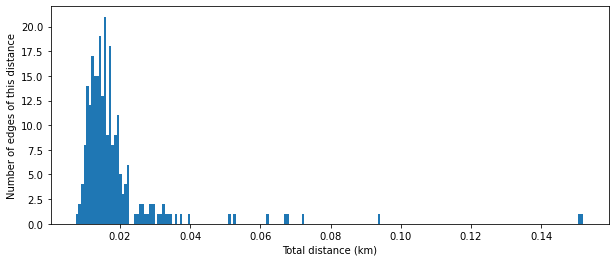

Number of nodes (buildings) in the graph:  77
Number of edges in the minimum spanning tree:  76
Total distance of minimum spanning tree (in km):  1.1680636717717219


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


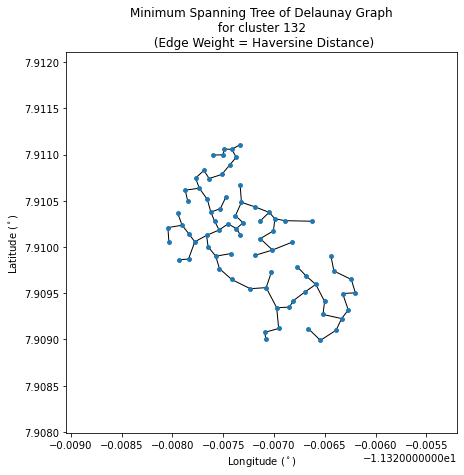

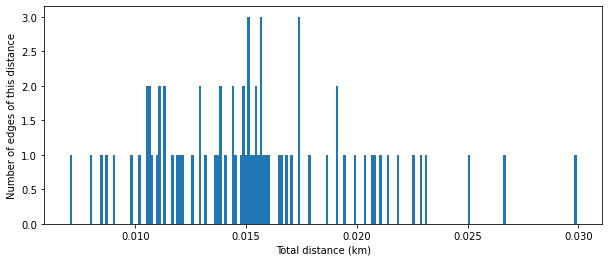

Number of nodes (buildings) in the graph:  143
Number of edges in the minimum spanning tree:  142
Total distance of minimum spanning tree (in km):  2.3481530930442305


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


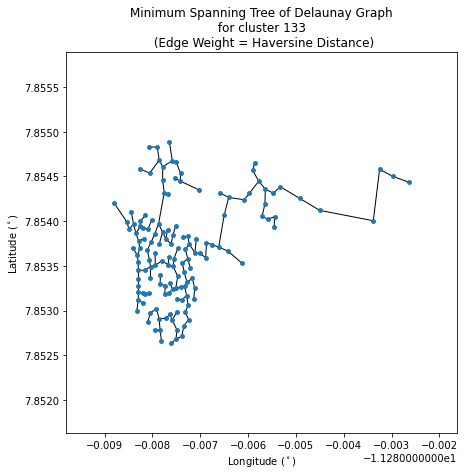

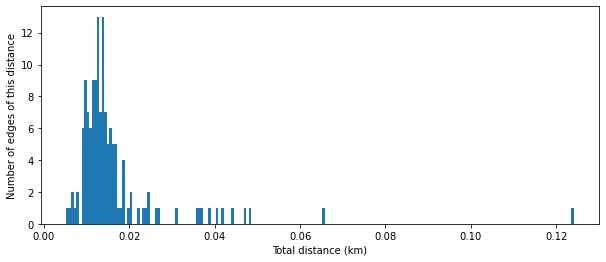

Number of nodes (buildings) in the graph:  109
Number of edges in the minimum spanning tree:  108
Total distance of minimum spanning tree (in km):  1.434056964449443


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


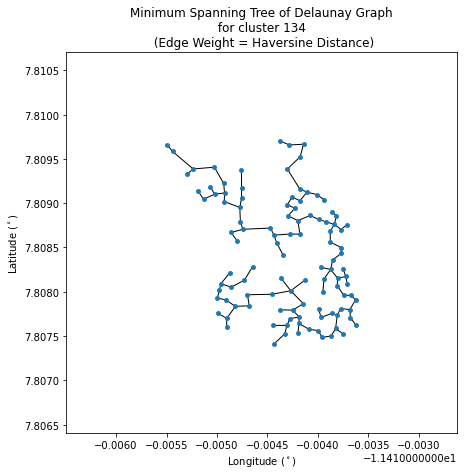

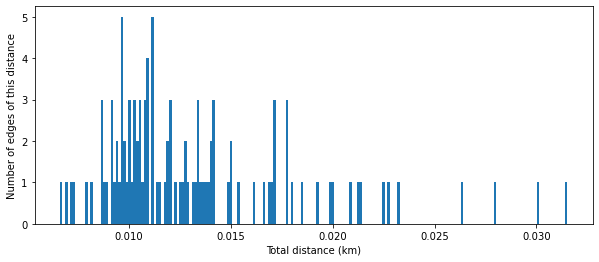

Number of nodes (buildings) in the graph:  93
Number of edges in the minimum spanning tree:  92
Total distance of minimum spanning tree (in km):  0.91537329881859


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


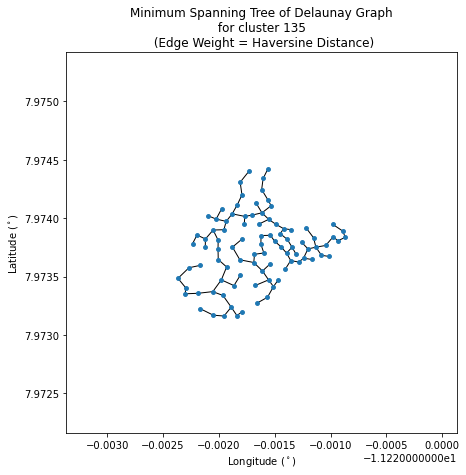

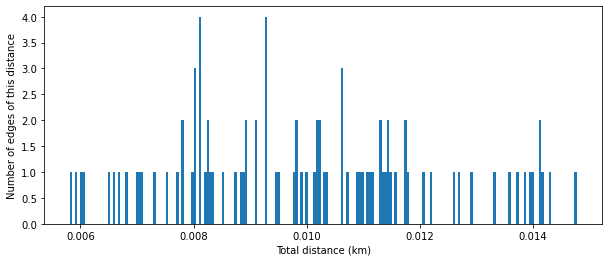

Number of nodes (buildings) in the graph:  129
Number of edges in the minimum spanning tree:  128
Total distance of minimum spanning tree (in km):  1.9226436768486803


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


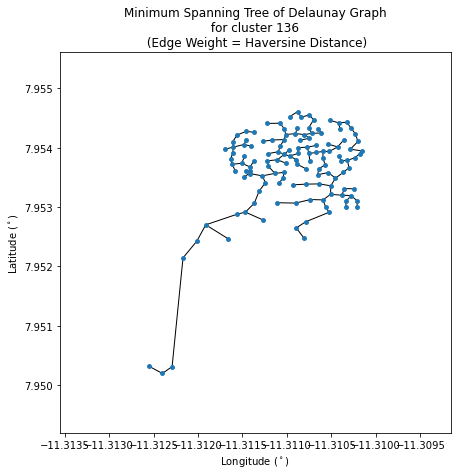

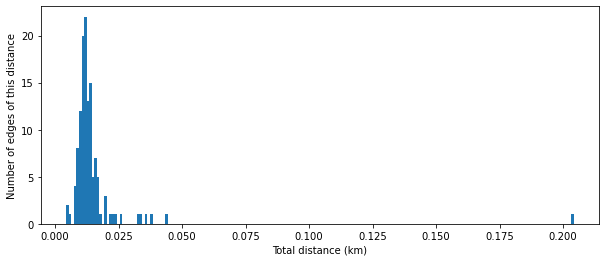

Number of nodes (buildings) in the graph:  99
Number of edges in the minimum spanning tree:  98
Total distance of minimum spanning tree (in km):  1.0610509529953807


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


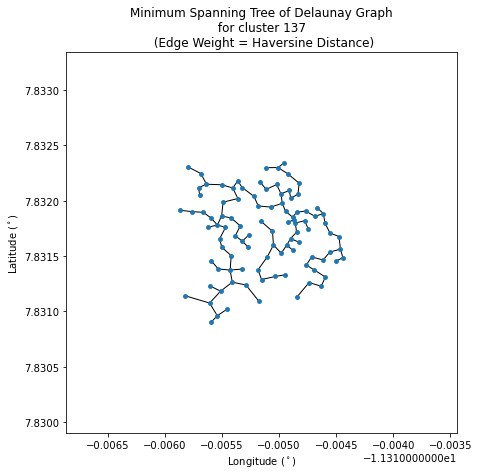

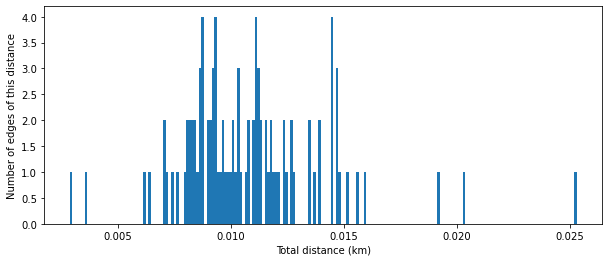

Number of nodes (buildings) in the graph:  82
Number of edges in the minimum spanning tree:  81
Total distance of minimum spanning tree (in km):  1.1270676351582212


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


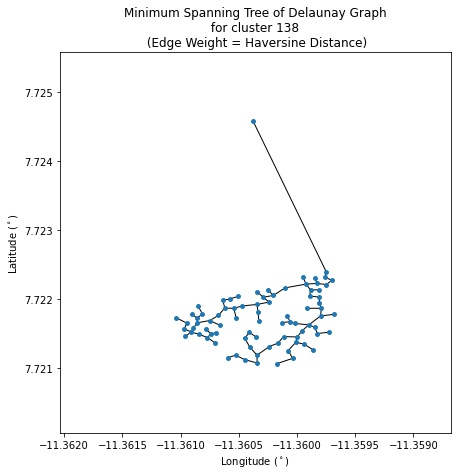

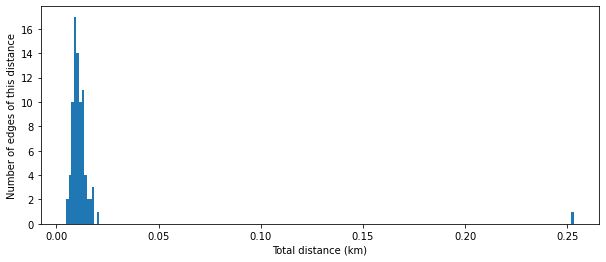

Number of nodes (buildings) in the graph:  92
Number of edges in the minimum spanning tree:  91
Total distance of minimum spanning tree (in km):  1.1381076661023686


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


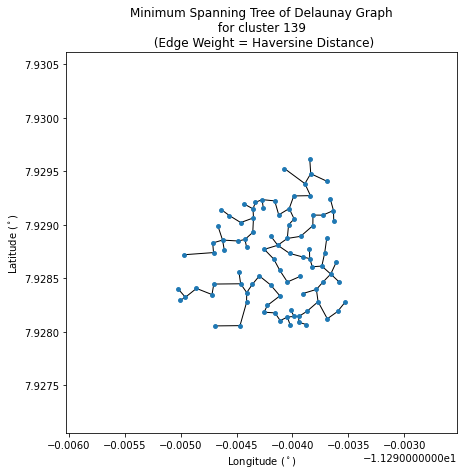

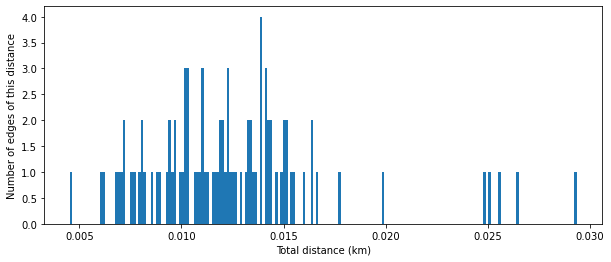

Number of nodes (buildings) in the graph:  76
Number of edges in the minimum spanning tree:  75
Total distance of minimum spanning tree (in km):  0.8059440848533318


C:\Users\micae\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


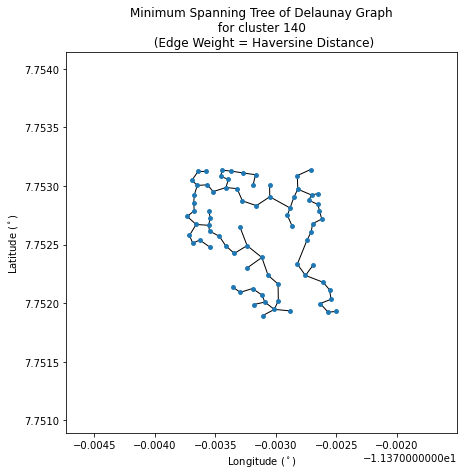

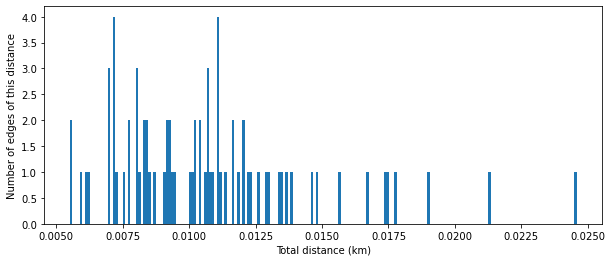

Nr Nodes Total Connection Distance
Cluster 1                 92                  1.439667
Cluster 2                228                   4.07473
Cluster 3                 68                  1.305285
Cluster 4                 50                  1.446499
Cluster 5                117                  1.848015
...                      ...                       ...
Cluster 139               92                  1.138108
Cluster 140               76                  0.805944
Total Transmission       140                363.044909
Total Distribution      6143                722.348121
Outliers                   0                       N/A

[143 rows x 2 columns]

In [16]:
nodes=list(range(len(centroid)+3))
distances=list(range(len(centroid)+3))
names=list(range(len(centroid)+3))
weights=list(range(len(centroid)+3))
distclust=0

#Plot cluster info
print("Cluster Details:")
for i in range(len(centroid)):
    nodes[i], distances[i],weights[i] = makeatree(coords,0,i)
    names[i]=f"Cluster {i+1}"
    distclust=distclust+distances[i]
nodes[i+1]=ngroups
distances[i+1]=tdists
names[i+1]="Total Transmission"
weights[i+1]=tweight

names[i+2]="Total Distribution"
nodes[i+2]=0
distances[i+2]=distclust

names[i+3]="Outliers"
nodes[i+3]=0
distances[i+3]="N/A"

nodes[i+2]=len(gdf)-sum(nodes)+nodes[i+1]

df2 = pd.DataFrame({
    "Nr Nodes" : nodes,
    "Total Connection Distance" : distances
    })
df2.index=names
df2

In [17]:
df2

Nr Nodes Total Connection Distance
Cluster 1                 92                  1.439667
Cluster 2                228                   4.07473
Cluster 3                 68                  1.305285
Cluster 4                 50                  1.446499
Cluster 5                117                  1.848015
...                      ...                       ...
Cluster 139               92                  1.138108
Cluster 140               76                  0.805944
Total Transmission       140                363.044909
Total Distribution      6143                722.348121
Outliers                   0                       N/A

[143 rows x 2 columns]

In [20]:
df2.to_csv("Cluster List2.csv")

In [21]:
df3.to_csv("Cluster List3.csv")

In [18]:
df2.mean(axis=0)

C:\Users\micae\AppData\Local\Temp/ipykernel_3040/3639053033.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df2.mean(axis=0)


Nr Nodes    306.923077
dtype: float64

In [19]:
nx.draw_networkx(T, pos, with_labels=True, labels=2, node_size=200, font_size=12, font_color="whitesmoke" )

NameError: name 'T' is not defined